# PART 1

In [54]:
import torch
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor

# Load your pre-trained or fine-tuned Wav2Vec2 model and processor
model_path = r"D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\modelos\wav2vec2-finetuned-ca-p3-1\checkpoint-24700"  # Adjust to your model path
model = Wav2Vec2ForCTC.from_pretrained(model_path)
processor = Wav2Vec2Processor.from_pretrained(r"D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\modelos\wav2vec2-finetuned-ca-p3-1")


Shape of pooled_gradients: torch.Size([1, 768])
Shape of activation_map: torch.Size([1, 179, 768])


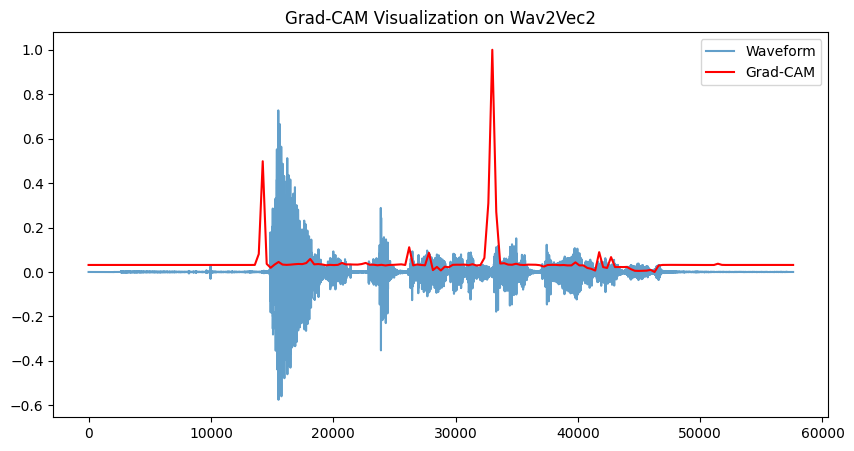

In [ ]:
import torch
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor

# Load your pre-trained or fine-tuned Wav2Vec2 model and processor
model_path = r"D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\modelos\wav2vec2-finetuned-ca-p3-1\checkpoint-24700"  # Adjust to your model path
model = Wav2Vec2ForCTC.from_pretrained(model_path)
processor = Wav2Vec2Processor.from_pretrained(r"D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\modelos\wav2vec2-finetuned-ca-p3-1")

# Load the target layer (e.g., the last attention layer)
target_layer = model.wav2vec2.encoder.layers[-1].attention  # Correctly access the attention module

# Hook to capture gradients
gradients = []
activations = []

def save_gradients(module, grad_in, grad_out):
    gradients.append(grad_out[0])  # Save the gradients from the target layer

def save_activations(module, input, output):
    activations.append(output)  # Save the activations from the forward pass

# Register hooks for gradients and activations
hook_grad = target_layer.register_backward_hook(save_gradients)
hook_act = target_layer.register_forward_hook(save_activations)

# Function to load and preprocess audio
def load_and_preprocess_audio(audio_path, processor):
    audio, sampling_rate = torchaudio.load(audio_path)
    if sampling_rate != 16000:
        resampler = torchaudio.transforms.Resample(orig_freq=sampling_rate, new_freq=16000)
        audio = resampler(audio)
    inputs = processor(audio.squeeze().numpy(), sampling_rate=16000, return_tensors="pt", padding=True)
    return inputs, audio

# Load and preprocess audio
audio_path = r"D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\ca\clips\common_voice_ca_40865561.mp3"  # Replace with your audio file path
inputs, audio = load_and_preprocess_audio(audio_path, processor)

# Forward pass through the model
inputs.requires_grad = True
logits = model(**inputs).logits

# Choose a target class (e.g., the most probable token)
target_class = torch.argmax(logits[0], dim=-1)[0].item()

# Backward pass to compute gradients
loss = logits[0, target_class].sum()  # Ensure the loss is scalar
loss.backward()

# Remove the hooks after computation
hook_grad.remove()
hook_act.remove()

# Retrieve the activation map and Grad-CAM weights
activation_map = activations[0][0]  # Extract the first tensor from the tuple
pooled_gradients = torch.mean(gradients[0], dim=1)  # Average over time

# Debug: Print shapes
print("Shape of pooled_gradients:", pooled_gradients.shape)
print("Shape of activation_map:", activation_map.shape)

# Reshape pooled_gradients to align with activation_map
pooled_gradients = pooled_gradients.unsqueeze(1)  # Shape: (1, 1, 768)

# Combine gradients with activations
grad_cam = torch.sum(pooled_gradients * activation_map, dim=-1).squeeze()  # Shape: (179,)

# Normalize the Grad-CAM map
grad_cam = grad_cam.detach().cpu().numpy()
grad_cam = (grad_cam - grad_cam.min()) / (grad_cam.max() - grad_cam.min())

# Visualize the Grad-CAM map over the waveform
plt.figure(figsize=(10, 5))
plt.plot(audio.squeeze().numpy(), alpha=0.7, label="Waveform")
plt.plot(
    np.linspace(0, len(audio.squeeze()), len(grad_cam)),
    grad_cam,
    label="Grad-CAM",
    color="red",
)
plt.legend()
plt.title("Grad-CAM Visualization on Wav2Vec2")
plt.show()


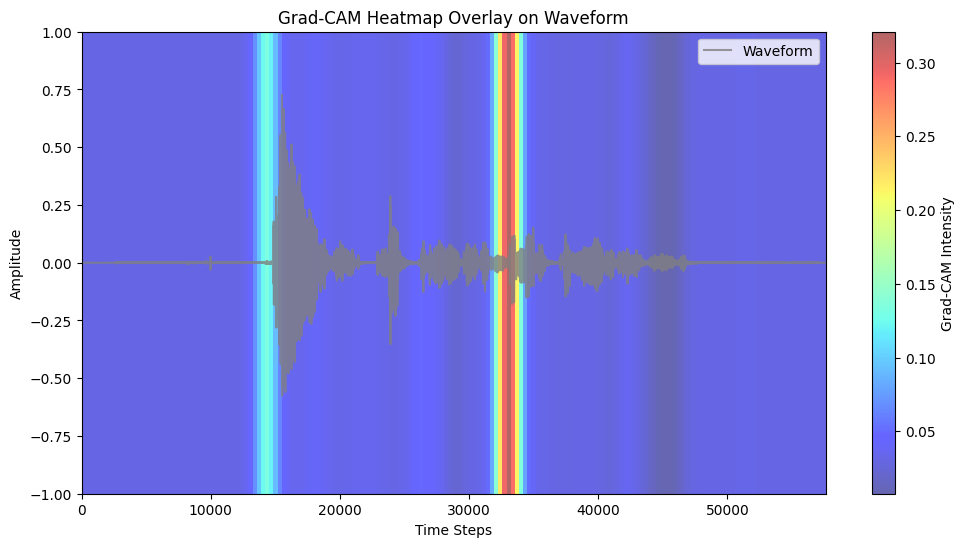

In [12]:
from scipy.ndimage import gaussian_filter1d

# Normalize Grad-CAM map and smooth it for better visualization
grad_cam_normalized = (grad_cam - grad_cam.min()) / (grad_cam.max() - grad_cam.min())
grad_cam_smoothed = gaussian_filter1d(grad_cam_normalized, sigma=2)  # Adjust sigma for smoothing

# Prepare the time axis for the heatmap
time_steps = np.linspace(0, len(audio.squeeze()), len(grad_cam_smoothed))

# Plot the waveform with the heatmap overlay
plt.figure(figsize=(12, 6))

# Plot the waveform
plt.plot(audio.squeeze().numpy(), color="gray", alpha=0.8, label="Waveform")

# Overlay the heatmap
plt.imshow(
    grad_cam_smoothed[np.newaxis, :],
    extent=[0, len(audio.squeeze()), -1, 1],  # Align heatmap with the waveform
    cmap="jet",
    aspect="auto",
    alpha=0.6,  # Transparency for blending with the waveform
)

# Add labels and legend
plt.colorbar(label="Grad-CAM Intensity")
plt.title("Grad-CAM Heatmap Overlay on Waveform")
plt.xlabel("Time Steps")
plt.ylabel("Amplitude")
plt.legend()
plt.show()


In [9]:
print("Activation map type:", type(activation_map))
print("Activation map content:", activation_map)


Activation map type: <class 'tuple'>
Activation map content: (tensor([[[-0.2281,  0.2299,  0.0537,  ...,  0.0074, -0.2248, -0.1544],
         [-0.2281,  0.2299,  0.0537,  ...,  0.0074, -0.2248, -0.1544],
         [-0.2281,  0.2299,  0.0537,  ...,  0.0074, -0.2248, -0.1544],
         ...,
         [-0.2281,  0.2299,  0.0537,  ...,  0.0074, -0.2248, -0.1544],
         [-0.2281,  0.2299,  0.0537,  ...,  0.0074, -0.2248, -0.1544],
         [-0.2281,  0.2299,  0.0537,  ...,  0.0074, -0.2248, -0.1544]]],
       grad_fn=<ViewBackward0>), None, None)


In [10]:
# Retrieve the activation map and Grad-CAM weights
activation_map = activations[0][0]  # Extract the first tensor from the tuple

pooled_gradients = torch.mean(gradients[0], dim=1)  # Average over time

# Debug: Print shapes
print("Shape of pooled_gradients:", pooled_gradients.shape)
print("Shape of activation_map:", activation_map.shape)

# Reshape pooled_gradients to align with activation_map
pooled_gradients = pooled_gradients.unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, num_features)

# Combine gradients with activations
grad_cam = torch.sum(pooled_gradients * activation_map, dim=-1).squeeze()  # Shape: (time_steps,)


Shape of pooled_gradients: torch.Size([1, 768])
Shape of activation_map: torch.Size([1, 179, 768])


In [13]:
import torch
import torchaudio
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor

# Load the audio file

audio, sampling_rate = torchaudio.load(audio_path)

# Resample if necessary
if sampling_rate != 16000:
    resampler = torchaudio.transforms.Resample(orig_freq=sampling_rate, new_freq=16000)
    audio = resampler(audio)


# Preprocess the audio
inputs = processor(audio.squeeze().numpy(), sampling_rate=16000, return_tensors="pt", padding=True)

# Perform inference
logits = model(**inputs).logits
predicted_ids = torch.argmax(logits, dim=-1)

# Decode the transcription
transcription = processor.batch_decode(predicted_ids)[0]
print("Transcription:", transcription)


Transcription: [UNK]u[UNK][UNK][UNK]s[UNK][UNK][UNK]al[UNK]prin[UNK]set[UNK]de[UNK]lestanebres[UNK]


In [3]:
import torch
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
import os

# Load your pre-trained or fine-tuned Wav2Vec2 model and processor
model_path = r"D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\modelos\wav2vec2-finetuned-ca-p3-1\checkpoint-24700"  # Adjust to your model path
model = Wav2Vec2ForCTC.from_pretrained(model_path)
processor = Wav2Vec2Processor.from_pretrained(r"D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\modelos\wav2vec2-finetuned-ca-p3-1")


# Function to compute Grad-CAM for a single audio file
def compute_gradcam(audio_path):
    # Load the target layer (e.g., the last attention layer)
    target_layer = model.wav2vec2.encoder.layers[-1].attention

    # Hook to capture gradients
    gradients = []
    activations = []

    def save_gradients(module, grad_in, grad_out):
        gradients.append(grad_out[0])  # Save the gradients from the target layer

    def save_activations(module, input, output):
        activations.append(output)  # Save the activations from the forward pass

    # Register hooks for gradients and activations
    hook_grad = target_layer.register_backward_hook(save_gradients)
    hook_act = target_layer.register_forward_hook(save_activations)

    # Load and preprocess audio
    def load_and_preprocess_audio(audio_path, processor):
        audio, sampling_rate = torchaudio.load(audio_path)
        if sampling_rate != 16000:
            resampler = torchaudio.transforms.Resample(orig_freq=sampling_rate, new_freq=16000)
            audio = resampler(audio)
        inputs = processor(audio.squeeze().numpy(), sampling_rate=16000, return_tensors="pt", padding=True)
        return inputs, audio

    inputs, audio = load_and_preprocess_audio(audio_path, processor)

    # Forward pass through the model
    inputs.requires_grad = True
    logits = model(**inputs).logits

    # Choose a target class (e.g., the most probable token)
    target_class = torch.argmax(logits[0], dim=-1)[0].item()

    # Backward pass to compute gradients
    loss = logits[0, target_class].sum()  # Ensure the loss is scalar
    loss.backward()

    # Remove the hooks after computation
    hook_grad.remove()
    hook_act.remove()

    # Retrieve the activation map and Grad-CAM weights
    activation_map = activations[0][0]  # Extract the first tensor from the tuple
    pooled_gradients = torch.mean(gradients[0], dim=1)  # Average over time

    # Debug: Print shapes
    print(f"Processing: {audio_path}")
    print("Shape of pooled_gradients:", pooled_gradients.shape)
    print("Shape of activation_map:", activation_map.shape)

    # Reshape pooled_gradients to align with activation_map
    pooled_gradients = pooled_gradients.unsqueeze(1)  # Shape: (1, 1, 768)

    # Combine gradients with activations
    grad_cam = torch.sum(pooled_gradients * activation_map, dim=-1).squeeze()  # Shape: (time_steps,)

    # Normalize the Grad-CAM map
    grad_cam = grad_cam.detach().cpu().numpy()
    grad_cam = (grad_cam - grad_cam.min()) / (grad_cam.max() - grad_cam.min())

    # Visualize the Grad-CAM map over the waveform
    plt.figure(figsize=(10, 5))
    plt.plot(audio.squeeze().numpy(), alpha=0.7, label="Waveform")
    plt.plot(
        np.linspace(0, len(audio.squeeze()), len(grad_cam)),
        grad_cam,
        label="Grad-CAM",
        color="red",
    )
    plt.legend()
    plt.title("Gradcam Visualization on:"f"{os.path.basename(audio_path)}")
    plt.show()



Processing: D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples\common_voice_ca_40865427.mp3


d:\Users\Usuario\anaconda3\envs\new_env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using non-full backward hooks on a Module that does not return a single Tensor or a tuple of Tensors is deprecated and will be removed in future versions. This hook will be missing some of the grad_output. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Processing: D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples\common_voice_ca_40865427.mp3
Shape of pooled_gradients: torch.Size([1, 768])
Shape of activation_map: torch.Size([1, 109, 768])


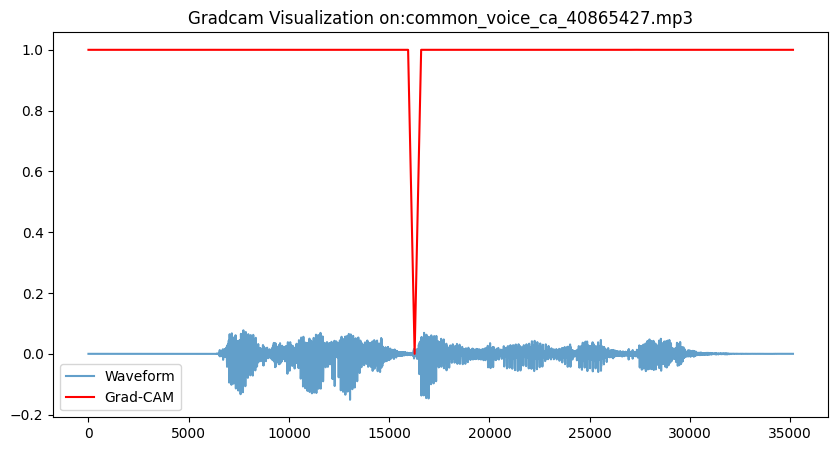

Processing: D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples\common_voice_ca_40865563.mp3
Processing: D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples\common_voice_ca_40865563.mp3
Shape of pooled_gradients: torch.Size([1, 768])
Shape of activation_map: torch.Size([1, 114, 768])


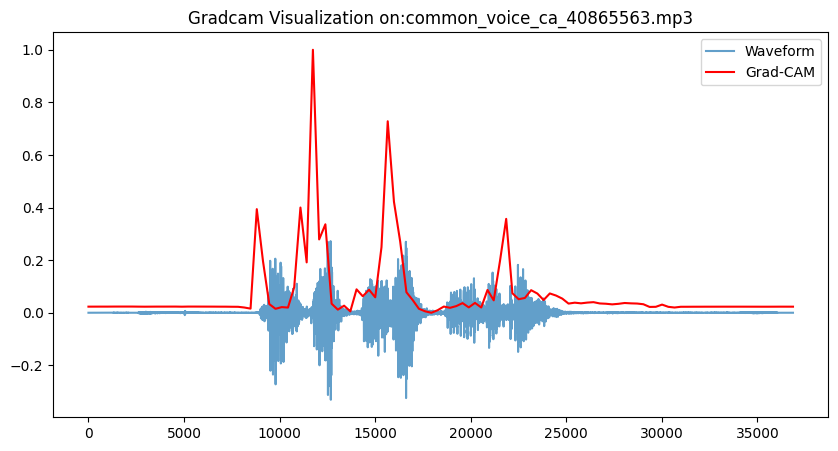

Processing: D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples\common_voice_ca_40866002.mp3
Processing: D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples\common_voice_ca_40866002.mp3
Shape of pooled_gradients: torch.Size([1, 768])
Shape of activation_map: torch.Size([1, 170, 768])


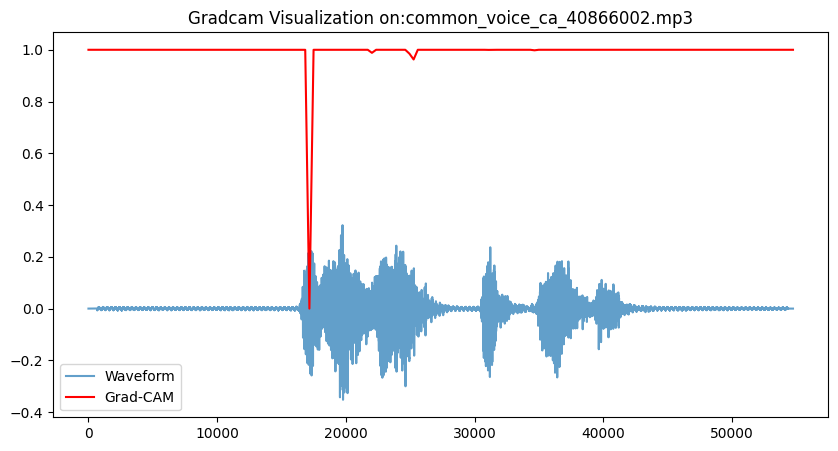

Processing: D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples\common_voice_ca_40866050.mp3
Processing: D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples\common_voice_ca_40866050.mp3
Shape of pooled_gradients: torch.Size([1, 768])
Shape of activation_map: torch.Size([1, 248, 768])


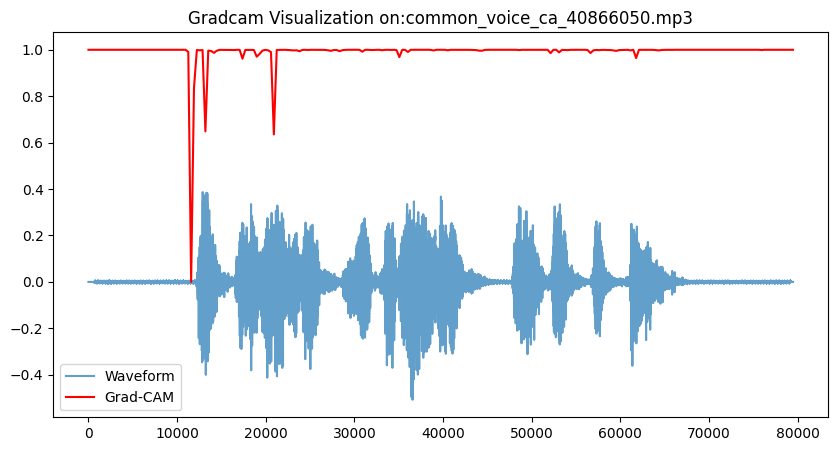

Processing: D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples\common_voice_ca_40866081.mp3
Processing: D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples\common_voice_ca_40866081.mp3
Shape of pooled_gradients: torch.Size([1, 768])
Shape of activation_map: torch.Size([1, 172, 768])


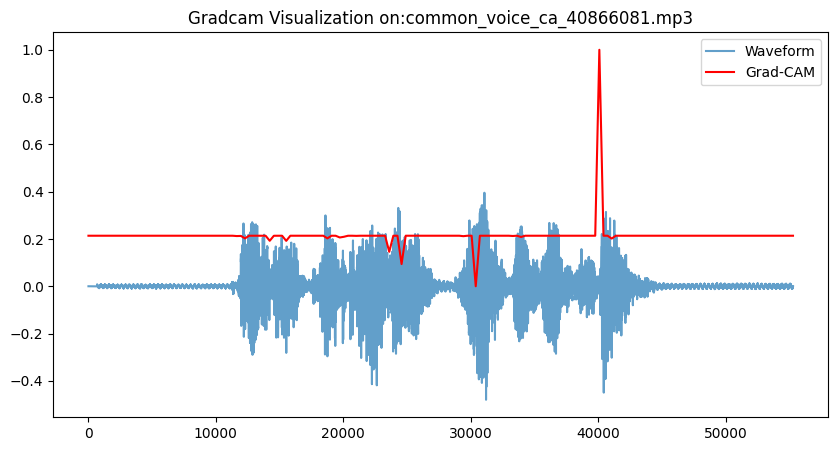

In [27]:
#iterate over the files in the folder
import os

audio_folder = r"D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples"
audio_files = os.listdir(audio_folder)

for audio_file in audio_files:
    audio_path = os.path.join(audio_folder, audio_file)
    print("Processing:", audio_path)
    compute_gradcam(audio_path)

In [4]:
from scipy.ndimage import gaussian_filter1d

# Function to compute Grad-CAM for a single audio file with heatmap visualization
def compute_gradcam_hm(audio_path):
    # Load the target layer (e.g., the last attention layer)
    target_layer = model.wav2vec2.encoder.layers[-1].attention

    # Hook to capture gradients
    gradients = []
    activations = []

    def save_gradients(module, grad_in, grad_out):
        gradients.append(grad_out[0])  # Save the gradients from the target layer

    def save_activations(module, input, output):
        activations.append(output)  # Save the activations from the forward pass

    # Register hooks for gradients and activations
    hook_grad = target_layer.register_backward_hook(save_gradients)
    hook_act = target_layer.register_forward_hook(save_activations)

    # Load and preprocess audio
    def load_and_preprocess_audio(audio_path, processor):
        audio, sampling_rate = torchaudio.load(audio_path)
        if sampling_rate != 16000:
            resampler = torchaudio.transforms.Resample(orig_freq=sampling_rate, new_freq=16000)
            audio = resampler(audio)
        inputs = processor(audio.squeeze().numpy(), sampling_rate=16000, return_tensors="pt", padding=True)
        return inputs, audio

    inputs, audio = load_and_preprocess_audio(audio_path, processor)

    # Forward pass through the model
    inputs.requires_grad = True
    logits = model(**inputs).logits

    # Choose a target class (e.g., the most probable token)
    target_class = torch.argmax(logits[0], dim=-1)[0].item()

    # Backward pass to compute gradients
    loss = logits[0, target_class].sum()  # Ensure the loss is scalar
    loss.backward()

    # Remove the hooks after computation
    hook_grad.remove()
    hook_act.remove()

    # Retrieve the activation map and Grad-CAM weights
    activation_map = activations[0][0]  # Extract the first tensor from the tuple
    pooled_gradients = torch.mean(gradients[0], dim=1)  # Average over time

    # Debug: Print shapes
    print(f"Processing: {audio_path}")
    print("Shape of pooled_gradients:", pooled_gradients.shape)
    print("Shape of activation_map:", activation_map.shape)

    # Reshape pooled_gradients to align with activation_map
    pooled_gradients = pooled_gradients.unsqueeze(1)  # Shape: (1, 1, 768)

    # Combine gradients with activations
    grad_cam = torch.sum(pooled_gradients * activation_map, dim=-1).squeeze()  # Shape: (time_steps,)

    # Normalize Grad-CAM map and smooth it for better visualization
    grad_cam_normalized = (grad_cam - grad_cam.min()) / (grad_cam.max() - grad_cam.min())
    grad_cam_normalized = grad_cam_normalized.detach().cpu().numpy()  # Detach and convert to NumPy
    grad_cam_smoothed = gaussian_filter1d(grad_cam_normalized, sigma=2)  # Adjust sigma for smoothing

    # Prepare the time axis for the heatmap
    time_steps = np.linspace(0, len(audio.squeeze()), len(grad_cam_smoothed))

    # Plot the waveform with the heatmap overlay
    plt.figure(figsize=(12, 6))

    # Plot the waveform
    plt.plot(audio.squeeze().numpy(), color="gray", alpha=0.8, label="Waveform")

    # Overlay the heatmap
    plt.imshow(
        grad_cam_smoothed[np.newaxis, :],
        extent=[0, len(audio.squeeze()), -1, 1],  # Align heatmap with the waveform
        cmap="jet",
        aspect="auto",
        alpha=0.6,  # Transparency for blending with the waveform
    )

    # Add labels and legend
    plt.colorbar(label="Grad-CAM Intensity")
    plt.title("Gradcam Visualization on:"f"{os.path.basename(audio_path)}")
    plt.xlabel("Time Steps")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()


Processing: D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples\common_voice_ca_40865427.mp3
Processing: D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples\common_voice_ca_40865427.mp3
Shape of pooled_gradients: torch.Size([1, 768])
Shape of activation_map: torch.Size([1, 109, 768])


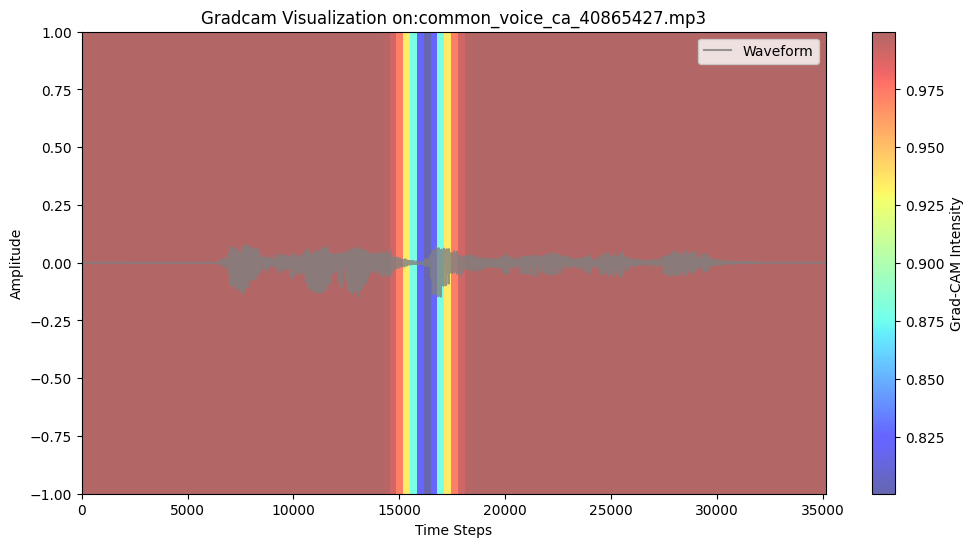

Processing: D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples\common_voice_ca_40865563.mp3
Processing: D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples\common_voice_ca_40865563.mp3
Shape of pooled_gradients: torch.Size([1, 768])
Shape of activation_map: torch.Size([1, 114, 768])


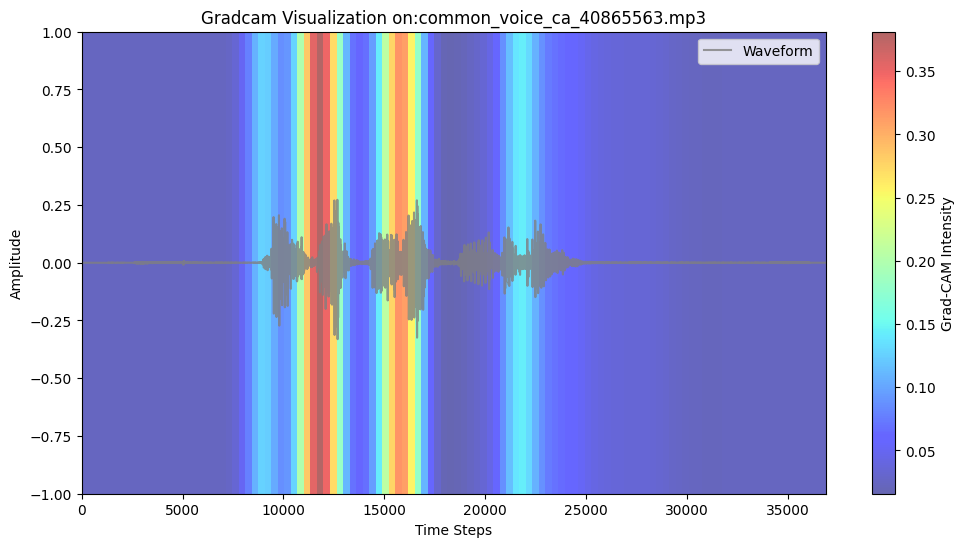

Processing: D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples\common_voice_ca_40866002.mp3
Processing: D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples\common_voice_ca_40866002.mp3
Shape of pooled_gradients: torch.Size([1, 768])
Shape of activation_map: torch.Size([1, 170, 768])


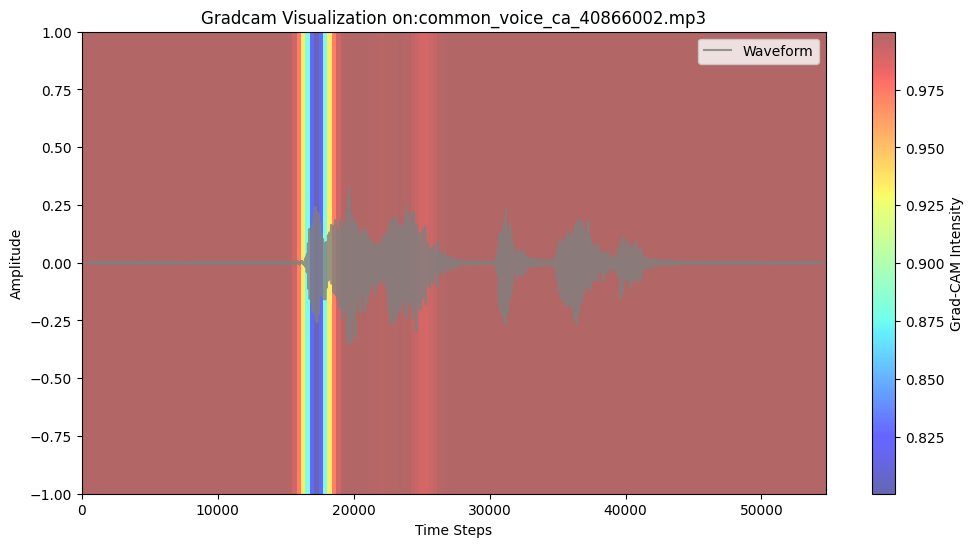

Processing: D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples\common_voice_ca_40866050.mp3
Processing: D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples\common_voice_ca_40866050.mp3
Shape of pooled_gradients: torch.Size([1, 768])
Shape of activation_map: torch.Size([1, 248, 768])


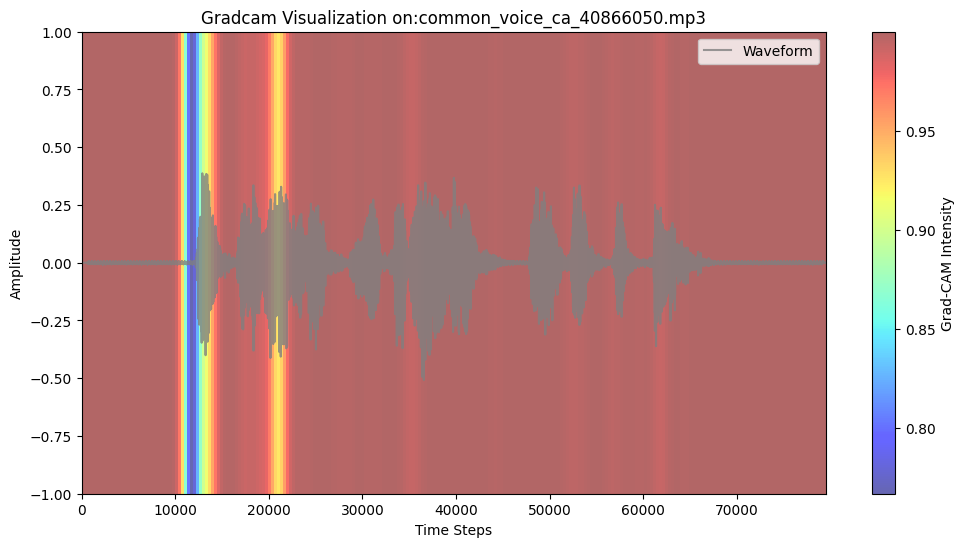

Processing: D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples\common_voice_ca_40866081.mp3
Processing: D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples\common_voice_ca_40866081.mp3
Shape of pooled_gradients: torch.Size([1, 768])
Shape of activation_map: torch.Size([1, 172, 768])


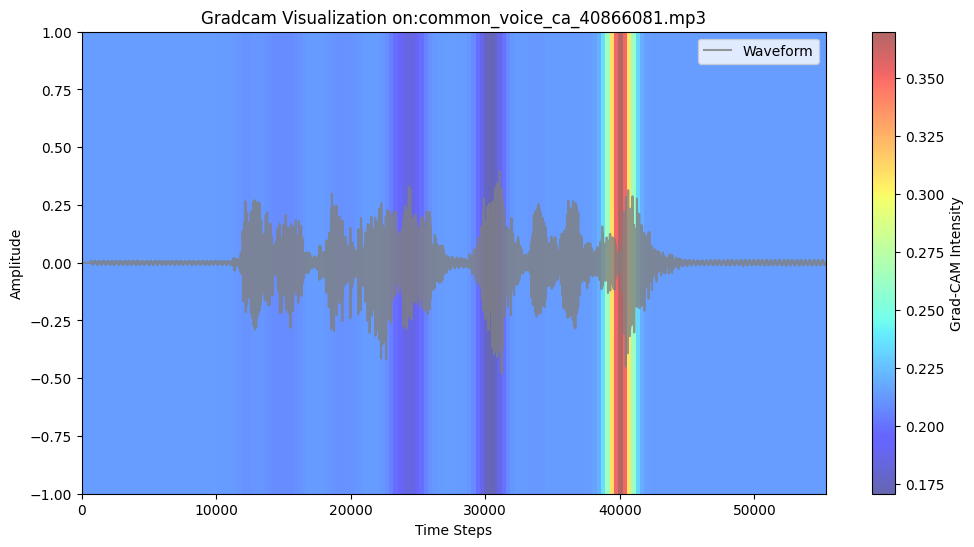

In [29]:
#compute Grad-CAM for all audio files in the folder
audio_folder = r"D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples"
audio_files = os.listdir(audio_folder)

for audio_file in audio_files:
    audio_path = os.path.join(audio_folder, audio_file)
    print("Processing:", audio_path)
    compute_gradcam_hm(audio_path)

In [5]:
import torch
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
from scipy.ndimage import gaussian_filter1d

def plot_grad_cam_spectrogram(audio_path):
    # ---------------------
    # Load model and processor
    # ---------------------
    model_path = r"D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\modelos\wav2vec2-finetuned-ca-p3-1\checkpoint-24700"  # Adjust to your model path
    model = Wav2Vec2ForCTC.from_pretrained(model_path)
    processor = Wav2Vec2Processor.from_pretrained(r"D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\modelos\wav2vec2-finetuned-ca-p3-1")

    
    # ---------------------
    # Set up hooks for Grad-CAM
    # ---------------------
    gradients = []
    activations = []
    
    target_layer = model.wav2vec2.encoder.layers[-1].attention

    def save_gradients(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    def save_activations(module, input, output):
        activations.append(output)

    hook_grad = target_layer.register_backward_hook(save_gradients)
    hook_act = target_layer.register_forward_hook(save_activations)

    # ---------------------
    # Load and preprocess audio
    # ---------------------
    audio, sampling_rate = torchaudio.load(audio_path)
    if sampling_rate != 16000:
        resampler = torchaudio.transforms.Resample(orig_freq=sampling_rate, new_freq=16000)
        audio = resampler(audio)

    inputs = processor(audio.squeeze().numpy(), sampling_rate=16000, return_tensors="pt", padding=True)
    inputs.requires_grad = True

    # ---------------------
    # Forward and backward pass
    # ---------------------
    logits = model(**inputs).logits
    target_class = torch.argmax(logits[0], dim=-1)[0].item()
    loss = logits[0, target_class].sum()
    loss.backward()

    # Remove hooks
    hook_grad.remove()
    hook_act.remove()

    # ---------------------
    # Compute Grad-CAM
    # ---------------------
    activation_map = activations[0][0]
    pooled_gradients = torch.mean(gradients[0], dim=1).unsqueeze(1)  # (num_heads, 1, hidden_size)
    grad_cam = torch.sum(pooled_gradients * activation_map, dim=-1).squeeze()
    grad_cam = grad_cam.detach().cpu().numpy()
    grad_cam = (grad_cam - grad_cam.min()) / (grad_cam.max() - grad_cam.min())
    grad_cam_smoothed = gaussian_filter1d(grad_cam, sigma=2)

    # ---------------------
    # Compute Spectrogram (Mel Spectrogram)
    # ---------------------
    mel_transform = torchaudio.transforms.MelSpectrogram(
        sample_rate=16000,
        n_mels=80,
        n_fft=400,
        win_length=400,
        hop_length=160,
        power=2.0
    )
    spec = mel_transform(audio)  # shape: [1, n_mels, time_frames]
    spec = spec[0]  # remove channel dimension -> [n_mels, time_frames]

    spec_db = torchaudio.functional.amplitude_to_DB(spec, multiplier=10.0, amin=1e-10, db_multiplier=0)
    spec_time_frames = spec_db.shape[1]
    grad_cam_time = len(grad_cam_smoothed)

    # Interpolate Grad-CAM to match spectrogram time dimension
    if grad_cam_time != spec_time_frames:
        grad_cam_resized = np.interp(
            np.linspace(0, grad_cam_time, spec_time_frames),
            np.arange(grad_cam_time),
            grad_cam_smoothed
        )
    else:
        grad_cam_resized = grad_cam_smoothed

    # Tile Grad-CAM across frequency dimension
    grad_cam_2d = np.tile(grad_cam_resized, (spec_db.shape[0], 1))

    # ---------------------
    # Plot Spectrogram and Grad-CAM Overlay
    # ---------------------
    plt.figure(figsize=(12, 6))

    # Plot spectrogram in dB
    plt.imshow(spec_db, aspect='auto', origin='lower', cmap='magma', interpolation='none')
    plt.colorbar(label="Spectrogram (dB)")

    # Overlay Grad-CAM heatmap
    plt.imshow(grad_cam_2d, aspect='auto', origin='lower', cmap='jet', alpha=0.0, interpolation='none')
    plt.title("Spectrogram with Grad-CAM Overlay")
    plt.xlabel("Time Frames")
    plt.ylabel("Mel Frequency Bins")
    cbar = plt.colorbar(label="Grad-CAM Intensity")
    plt.show()




Processing: D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples\common_voice_ca_40865427.mp3


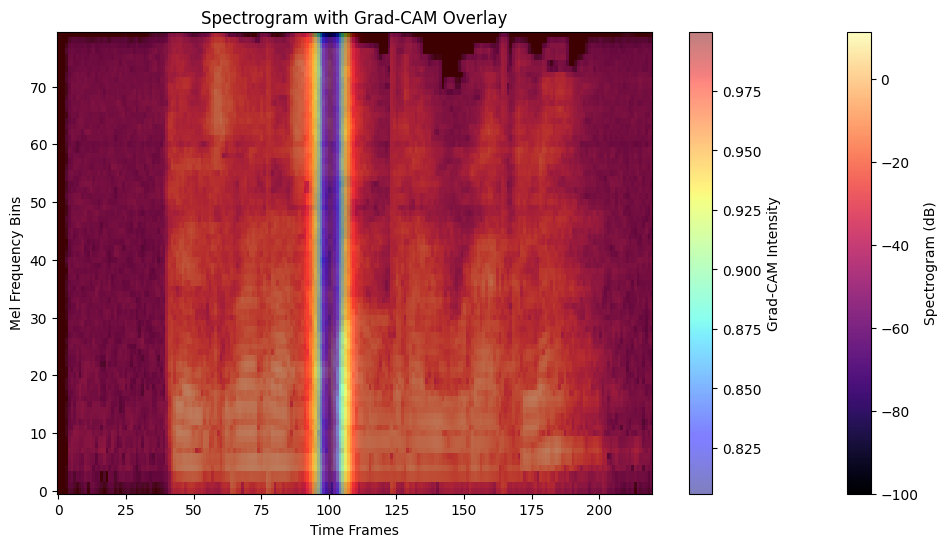

Processing: D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples\common_voice_ca_40865563.mp3


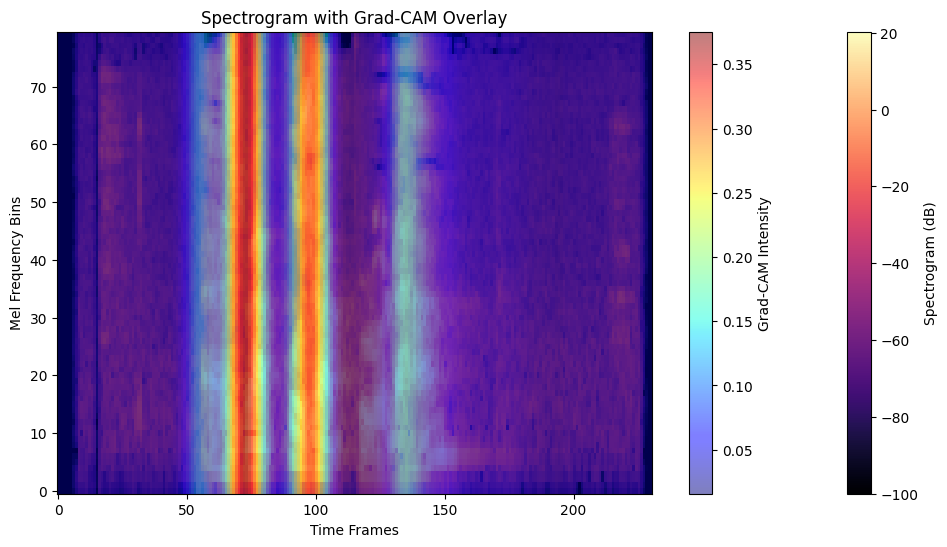

Processing: D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples\common_voice_ca_40866002.mp3


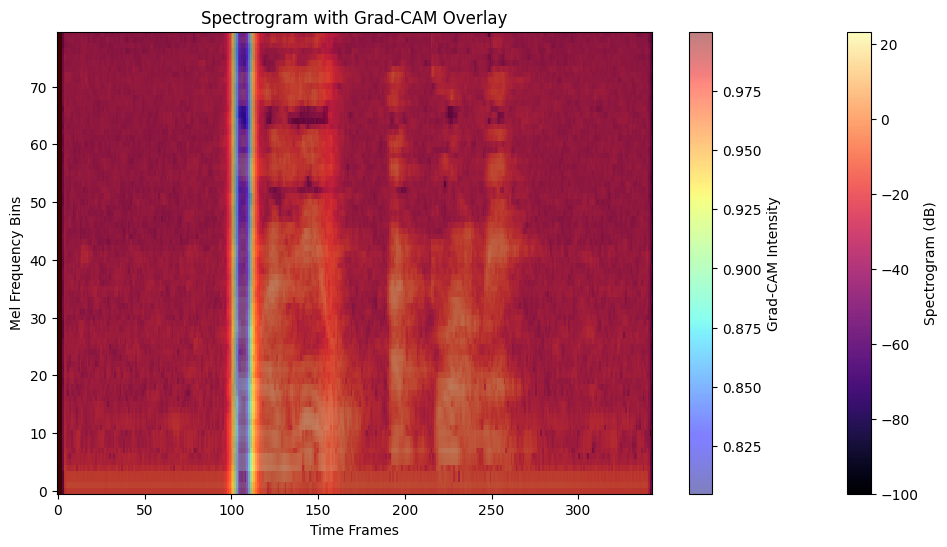

Processing: D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples\common_voice_ca_40866050.mp3


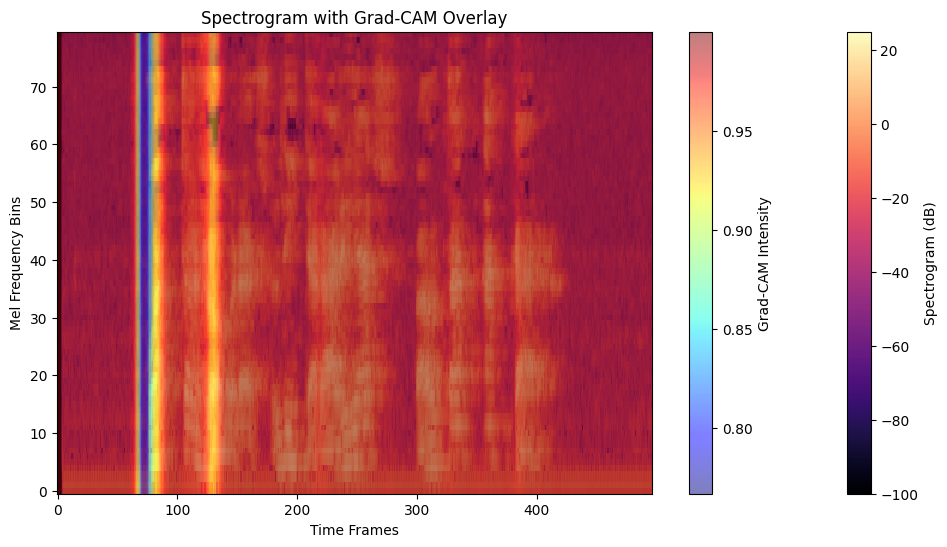

Processing: D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples\common_voice_ca_40866081.mp3


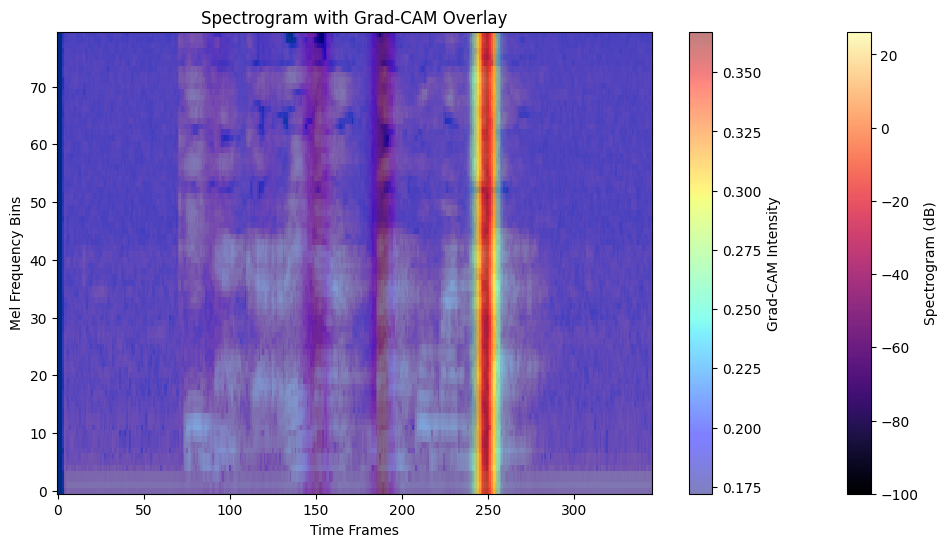

In [ ]:
# call the function with the audio file path for all audio files in a folder
audio_folder = r"D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples"
audio_files = os.listdir(audio_folder)

for audio_file in audio_files:
    audio_path = os.path.join(audio_folder, audio_file)
    print("Processing:", audio_path)
    plot_grad_cam_spectrogram(audio_path)



Processing: D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples\common_voice_ca_40865427.mp3


d:\Users\Usuario\anaconda3\envs\new_env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using non-full backward hooks on a Module that does not return a single Tensor or a tuple of Tensors is deprecated and will be removed in future versions. This hook will be missing some of the grad_output. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


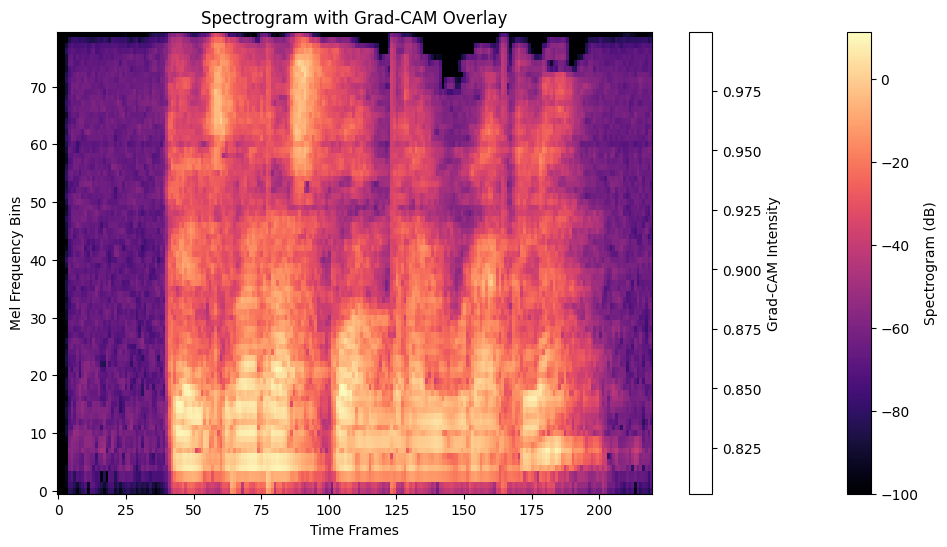

Processing: D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples\common_voice_ca_40865563.mp3


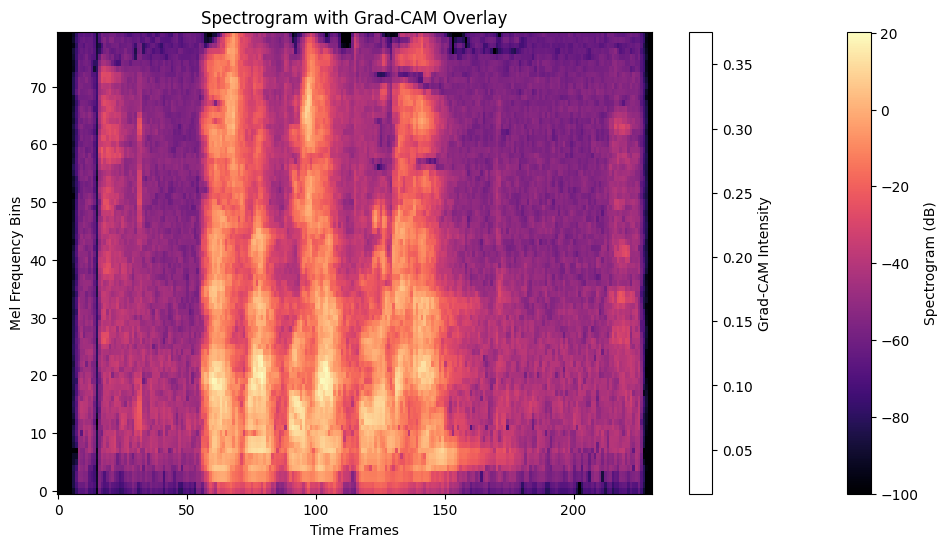

Processing: D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples\common_voice_ca_40866002.mp3


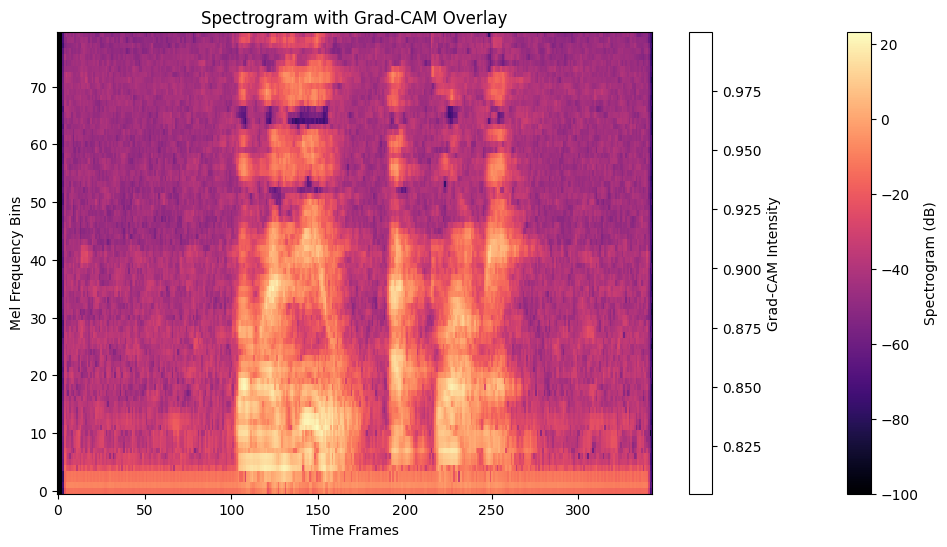

Processing: D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples\common_voice_ca_40866050.mp3


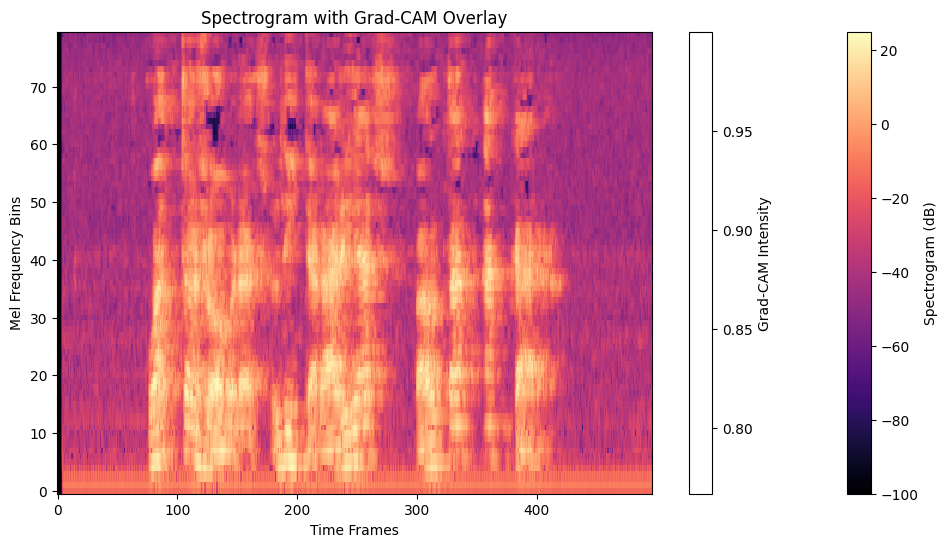

Processing: D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples\common_voice_ca_40866081.mp3


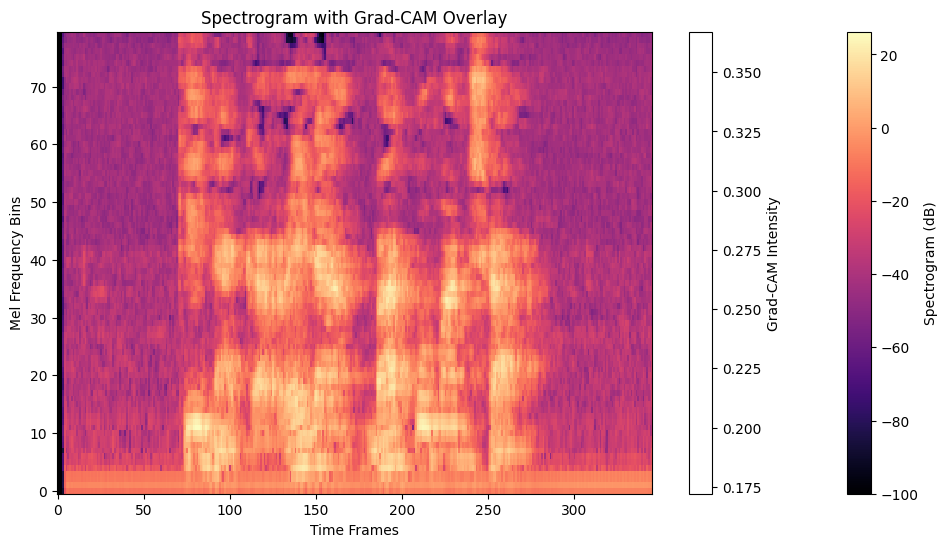

In [ ]:
# call the function with the audio file path for all audio files in a folder
audio_folder = r"D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples"
audio_files = os.listdir(audio_folder)

for audio_file in audio_files:
    audio_path = os.path.join(audio_folder, audio_file)
    print("Processing:", audio_path)
    plot_grad_cam_spectrogram(audio_path)
'''

AQUI ES SIN GRADCAM PARA VER EL ESPECTOGRAMA

'''

Processing: D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples\common_voice_ca_40865427.mp3


d:\Users\Usuario\anaconda3\envs\new_env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using non-full backward hooks on a Module that does not return a single Tensor or a tuple of Tensors is deprecated and will be removed in future versions. This hook will be missing some of the grad_output. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


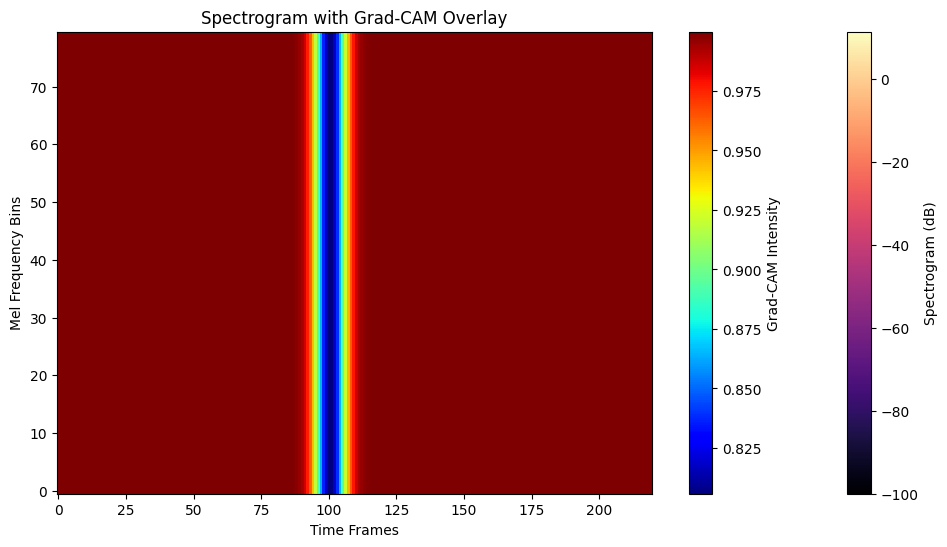

Processing: D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples\common_voice_ca_40865563.mp3


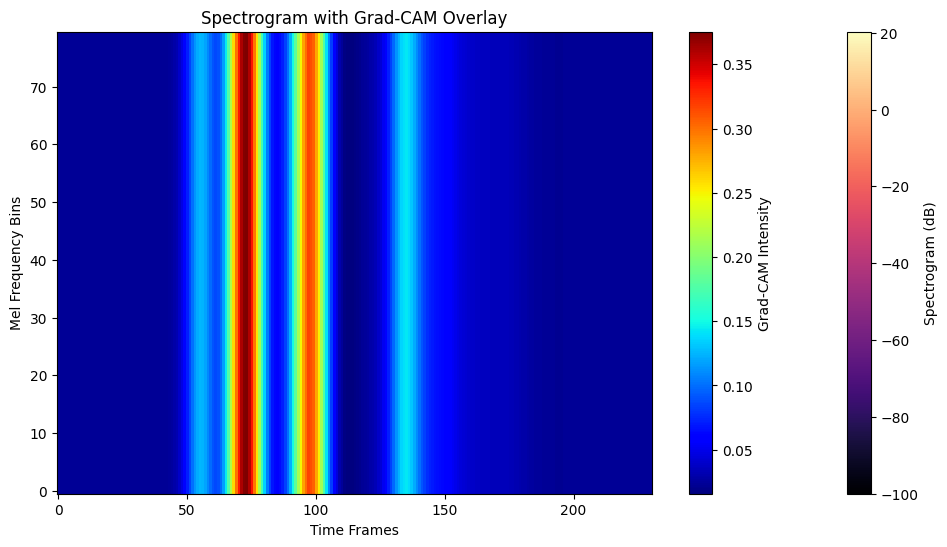

Processing: D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples\common_voice_ca_40866002.mp3


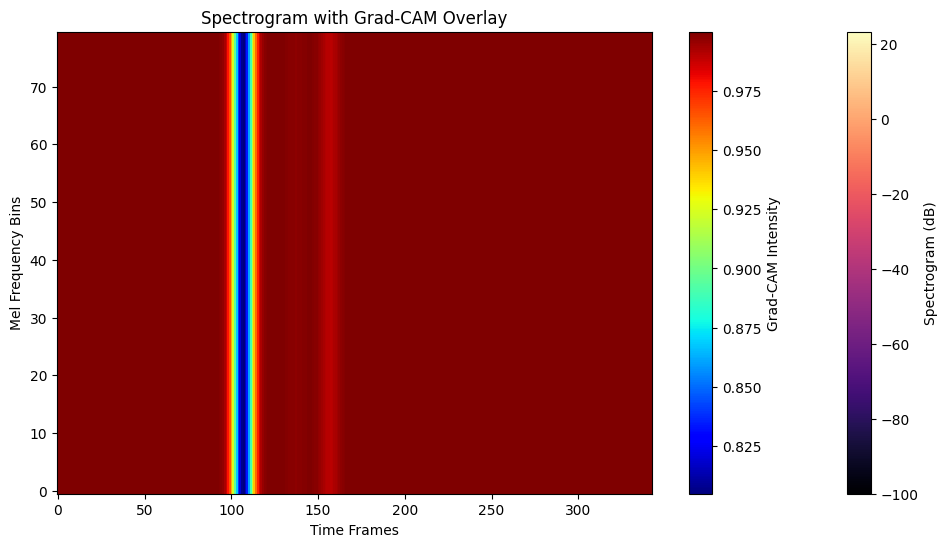

Processing: D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples\common_voice_ca_40866050.mp3


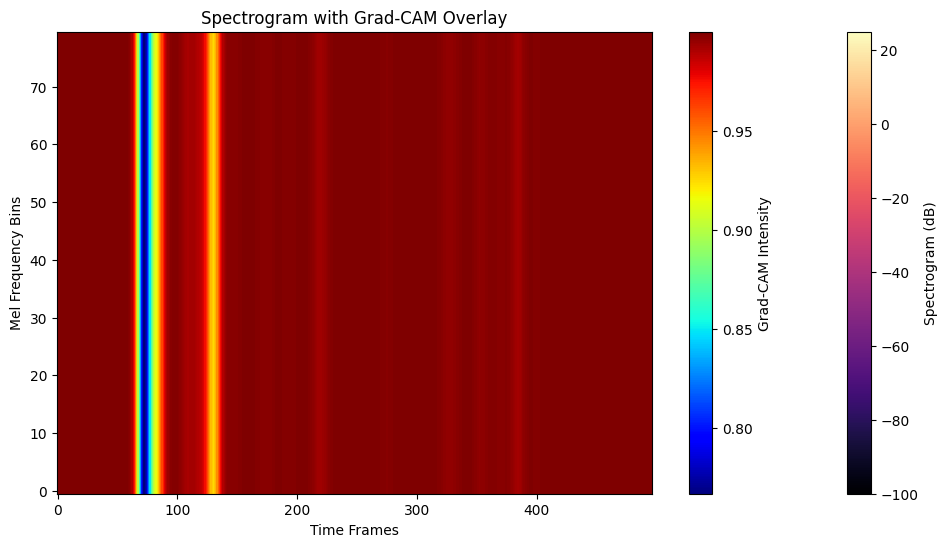

Processing: D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples\common_voice_ca_40866081.mp3


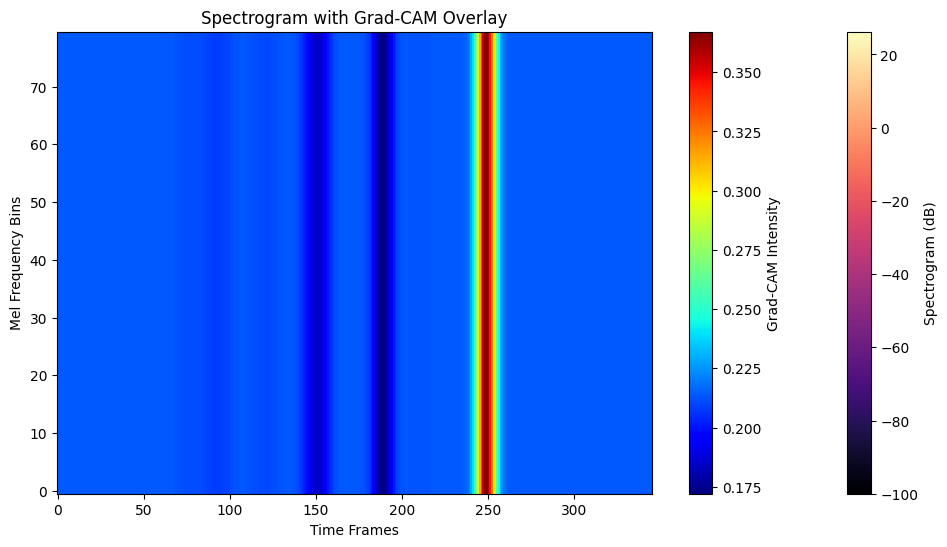

'\n\nAQUI ES SIN GRADCAM PARA VER EL ESPECTOGRAMA\n\n'

In [74]:
# call the function with the audio file path for all audio files in a folder
audio_folder = r"D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples"
audio_files = os.listdir(audio_folder)

for audio_file in audio_files:
    audio_path = os.path.join(audio_folder, audio_file)
    print("Processing:", audio_path)
    plot_grad_cam_spectrogram(audio_path)
'''

AQUI ES SIN ESPECTOGRAMA PARA VER EL GRADCAM

'''

In [69]:
import torch
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
from difflib import SequenceMatcher
from sklearn.manifold import TSNE

def plot_embedding_projections(
    audio_path, 
    ground_truth_text, 
    layer_index=-1
):
    # ---------------------
    # Load model and processor with hidden states
    # ---------------------
    model_path = r"D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\modelos\wav2vec2-finetuned-ca-p3-1\checkpoint-24700"  # Adjust to your model path
    model = Wav2Vec2ForCTC.from_pretrained(model_path, output_hidden_states=True)
    processor = Wav2Vec2Processor.from_pretrained(r"D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\modelos\wav2vec2-finetuned-ca-p3-1")


    # ---------------------
    # Load and preprocess audio
    # ---------------------
    audio, sampling_rate = torchaudio.load(audio_path)
    if sampling_rate != 16000:
        resampler = torchaudio.transforms.Resample(orig_freq=sampling_rate, new_freq=16000)
        audio = resampler(audio)

    inputs = processor(audio.squeeze().numpy(), sampling_rate=16000, return_tensors="pt", padding=True)

    with torch.no_grad():
        outputs = model(**inputs)

    # Ensure hidden_states is available
    if not hasattr(outputs, "hidden_states") or outputs.hidden_states is None:
        raise ValueError("No hidden_states found. Make sure the model is loaded with output_hidden_states=True.")

    # Extract embeddings from a specified layer. layer_index = -1 means last layer
    hidden_states = outputs.hidden_states[layer_index]
    # hidden_states shape: [batch_size, time_steps, hidden_dim]
    embeddings = hidden_states[0].cpu().numpy()  # remove batch dimension
    
    # ---------------------
    # Decode predicted transcript
    # ---------------------
    predicted_ids = torch.argmax(outputs.logits, dim=-1)
    prediction = processor.batch_decode(predicted_ids)[0]

    # Word-level comparison
    gt_words = ground_truth_text.strip().split()
    pred_words = prediction.strip().split()

    matcher = SequenceMatcher(None, gt_words, pred_words)
    opcodes = matcher.get_opcodes()

    # Identify correctness of predicted words
    correctness_map = [False] * len(pred_words)
    for tag, i1, i2, j1, j2 in opcodes:
        if tag == 'equal':
            for idx in range(j1, j2):
                correctness_map[idx] = True

    # Approximate mapping of frames to predicted words
    time_steps = embeddings.shape[0]
    num_pred_words = len(pred_words)
    if num_pred_words == 0:
        print("No predicted words.")
        return

    segment_length = time_steps / num_pred_words
    frame_word_idx = []
    for i in range(time_steps):
        word_index = min(int(i / segment_length), num_pred_words - 1)
        frame_word_idx.append(word_index)

    # Create color labels for each frame
    frame_colors = []
    for i in range(time_steps):
        w_idx = frame_word_idx[i]
        color = 'green' if correctness_map[w_idx] else 'red'
        frame_colors.append(color)

    # ---------------------
    # Dimensionality Reduction (t-SNE)
    # ---------------------
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    embeddings_2d = tsne.fit_transform(embeddings)

    # ---------------------
    # Plot the t-SNE Projection
    # ---------------------
    fig, ax = plt.subplots(figsize=(10, 6))

    # Separate the embeddings by color (correct vs incorrect)
    correct_idxs = [i for i, c in enumerate(frame_colors) if c == 'green']
    incorrect_idxs = [i for i, c in enumerate(frame_colors) if c == 'red']

    ax.scatter(embeddings_2d[correct_idxs, 0], embeddings_2d[correct_idxs, 1], c='green', alpha=0.5, label="Correct Word Frames")
    ax.scatter(embeddings_2d[incorrect_idxs, 0], embeddings_2d[incorrect_idxs, 1], c='red', alpha=0.5, label="Incorrect Word Frames")

    ax.set_title("t-SNE Projection of Audio Embeddings")
    ax.set_xlabel("Dimension 1")
    ax.set_ylabel("Dimension 2")
    ax.legend(loc='best')

    plt.show()



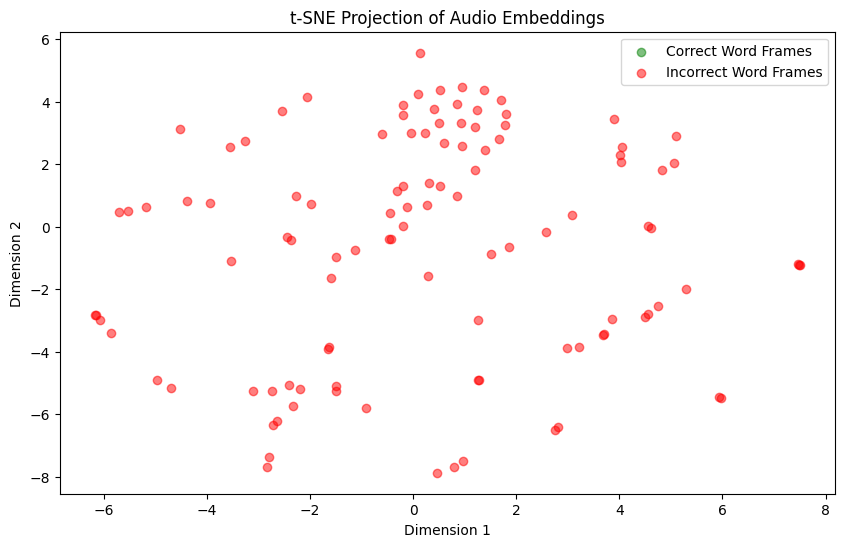

In [70]:
# call the function with the audio file path for first audio file in the folder
audio_folder = r"D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples"
audio_files = os.listdir(audio_folder)
audio_path = os.path.join(audio_folder, audio_files[0])
ground_truth_text = "Què els va respondre l'oracle?"

plot_embedding_projections(audio_path, ground_truth_text, layer_index=-1)


# PART 2

In [1]:
import torch
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor

# Load your pre-trained or fine-tuned Wav2Vec2 model and processor
model_path = r"D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\modelos\wav2vec2-finetuned-ca-p3-1\checkpoint-24700"  # Adjust to your model path
model = Wav2Vec2ForCTC.from_pretrained(model_path)
processor = Wav2Vec2Processor.from_pretrained(r"D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\modelos\wav2vec2-finetuned-ca-p3-1")


d:\Users\Usuario\anaconda3\envs\new_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Processing: D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples2\common_voice_ca_40865427.mp3


d:\Users\Usuario\anaconda3\envs\new_env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using non-full backward hooks on a Module that does not return a single Tensor or a tuple of Tensors is deprecated and will be removed in future versions. This hook will be missing some of the grad_output. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Processing: D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples2\common_voice_ca_40865427.mp3
Shape of pooled_gradients: torch.Size([1, 768])
Shape of activation_map: torch.Size([1, 109, 768])


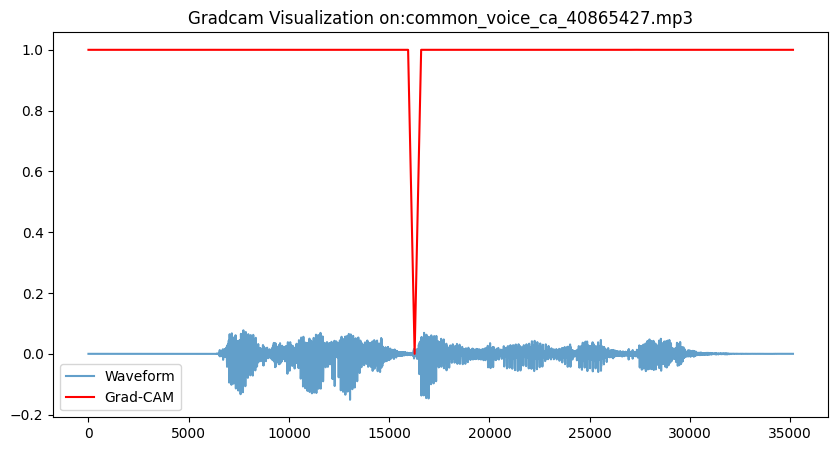

Processing: D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples2\common_voice_ca_40865467.mp3
Processing: D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples2\common_voice_ca_40865467.mp3
Shape of pooled_gradients: torch.Size([1, 768])
Shape of activation_map: torch.Size([1, 208, 768])


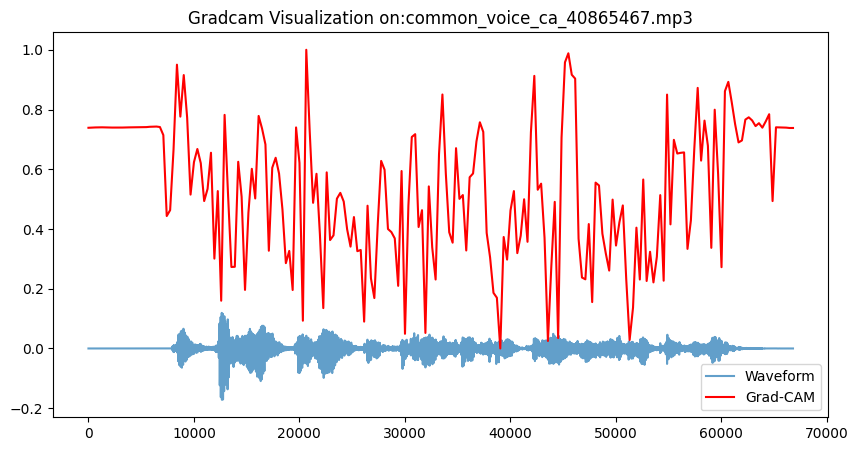

Processing: D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples2\common_voice_ca_40866081.mp3
Processing: D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples2\common_voice_ca_40866081.mp3
Shape of pooled_gradients: torch.Size([1, 768])
Shape of activation_map: torch.Size([1, 172, 768])


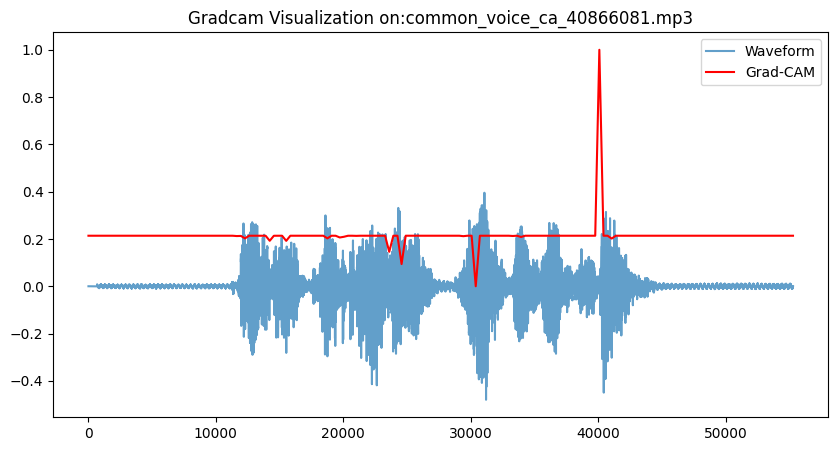

Processing: D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples2\common_voice_ca_40866683.mp3
Processing: D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples2\common_voice_ca_40866683.mp3
Shape of pooled_gradients: torch.Size([1, 768])
Shape of activation_map: torch.Size([1, 147, 768])


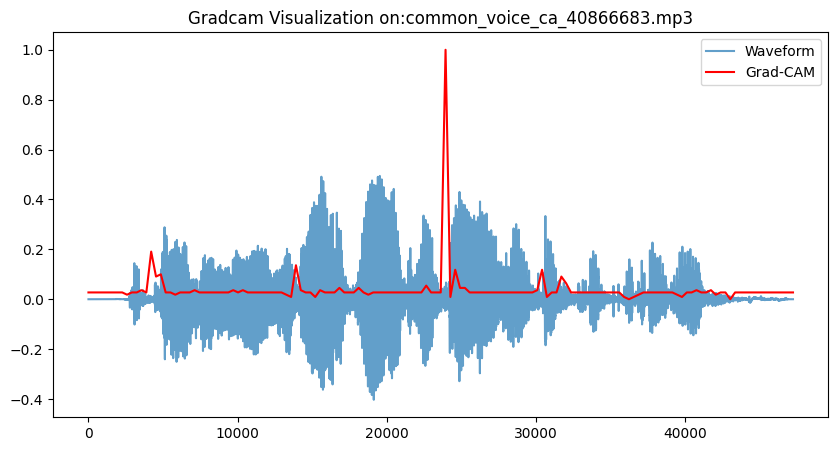

In [3]:
#iterate over the files in the folder
import os

audio_folder = r"D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples2"
audio_files = os.listdir(audio_folder)

for audio_file in audio_files:
    audio_path = os.path.join(audio_folder, audio_file)
    print("Processing:", audio_path)
    compute_gradcam(audio_path)

Processing: D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples2\common_voice_ca_40865427.mp3
Processing: D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples2\common_voice_ca_40865427.mp3
Shape of pooled_gradients: torch.Size([1, 768])
Shape of activation_map: torch.Size([1, 109, 768])


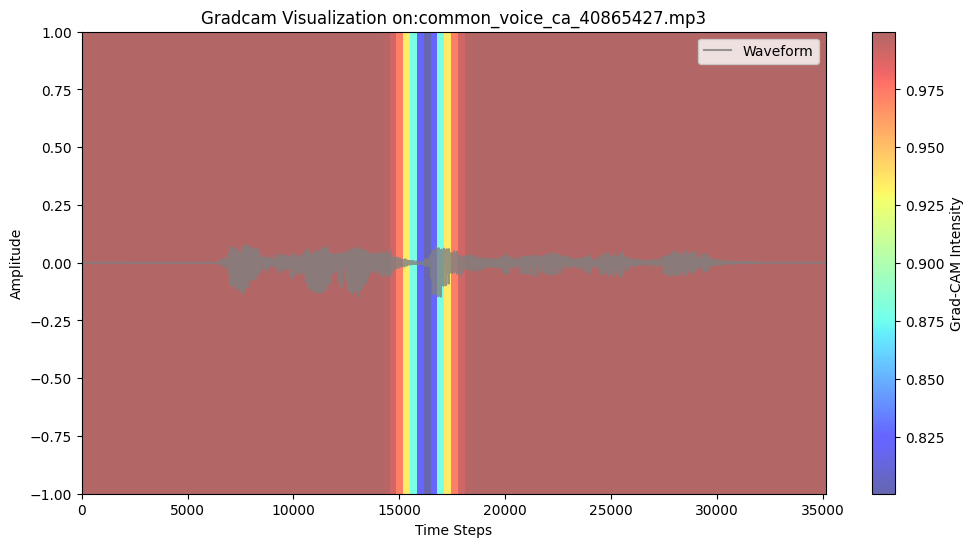

Processing: D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples2\common_voice_ca_40865467.mp3
Processing: D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples2\common_voice_ca_40865467.mp3
Shape of pooled_gradients: torch.Size([1, 768])
Shape of activation_map: torch.Size([1, 208, 768])


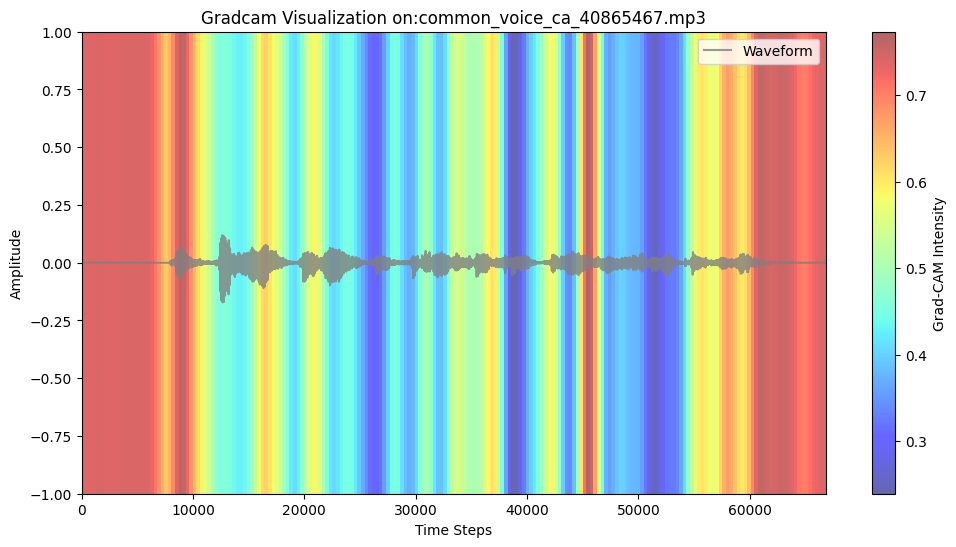

Processing: D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples2\common_voice_ca_40866081.mp3
Processing: D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples2\common_voice_ca_40866081.mp3
Shape of pooled_gradients: torch.Size([1, 768])
Shape of activation_map: torch.Size([1, 172, 768])


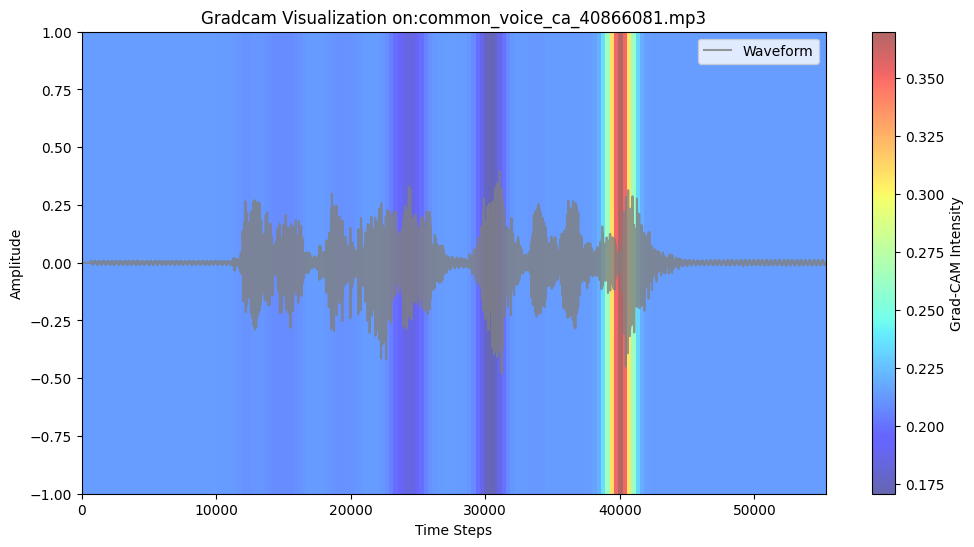

Processing: D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples2\common_voice_ca_40866683.mp3
Processing: D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples2\common_voice_ca_40866683.mp3
Shape of pooled_gradients: torch.Size([1, 768])
Shape of activation_map: torch.Size([1, 147, 768])


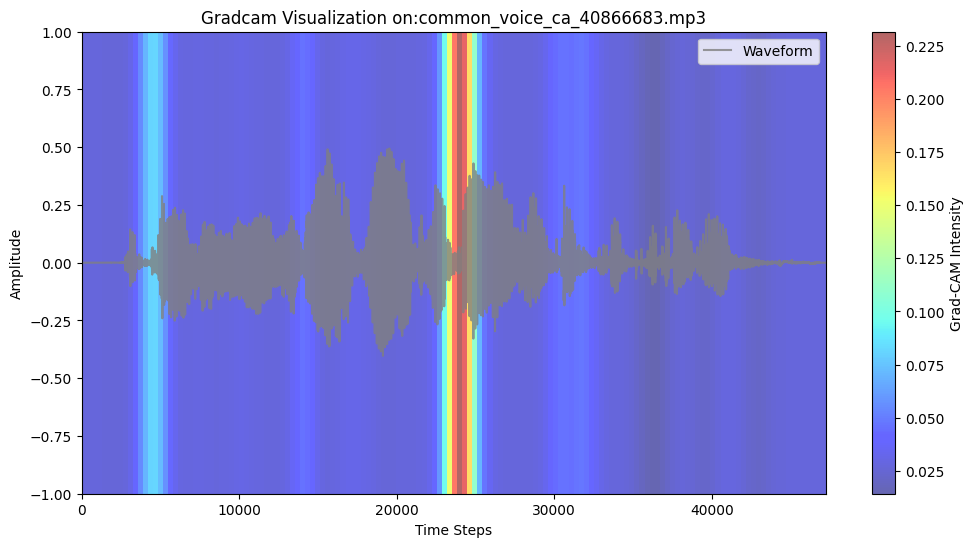

In [5]:
#compute Grad-CAM for all audio files in the folder
audio_folder = r"D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples2"
audio_files = os.listdir(audio_folder)

for audio_file in audio_files:
    audio_path = os.path.join(audio_folder, audio_file)
    print("Processing:", audio_path)
    compute_gradcam_hm(audio_path)

Processing: D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples2\common_voice_ca_40865427.mp3


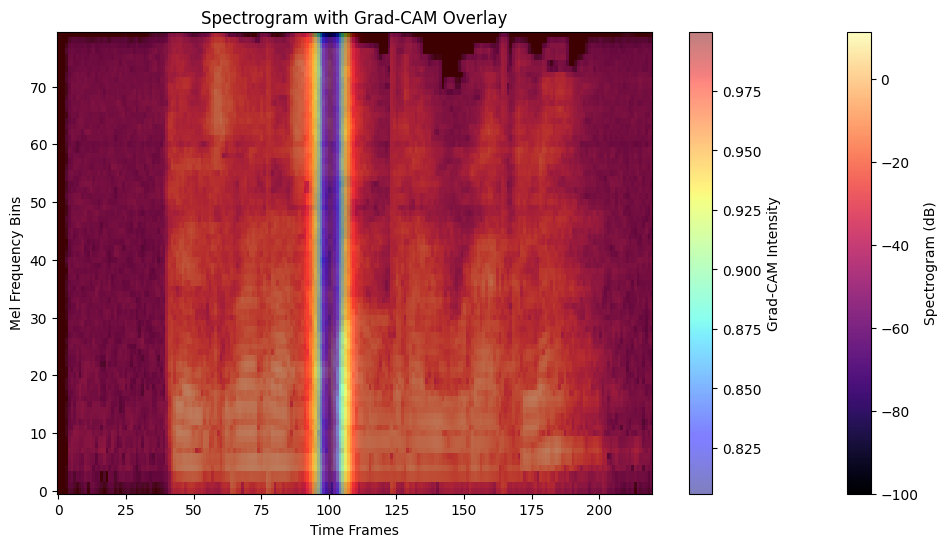

Processing: D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples2\common_voice_ca_40865467.mp3


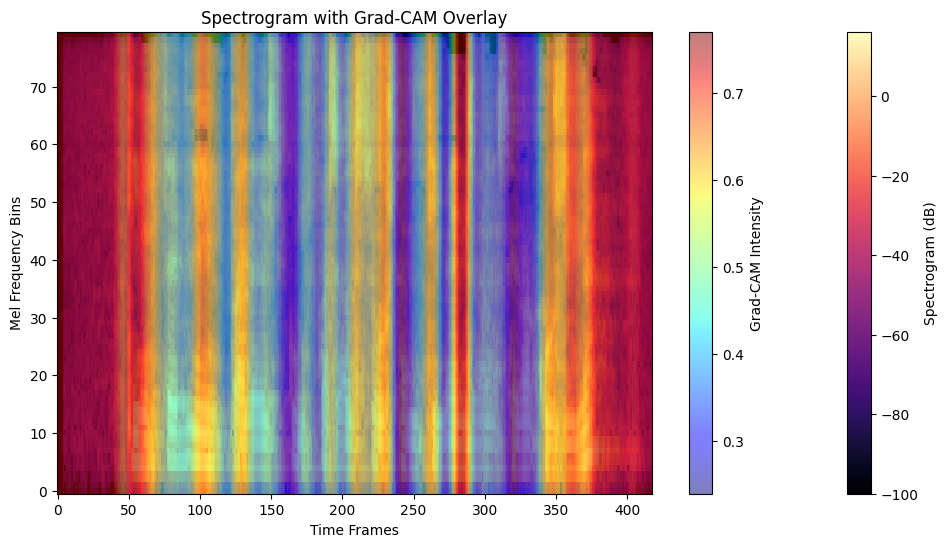

Processing: D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples2\common_voice_ca_40866081.mp3


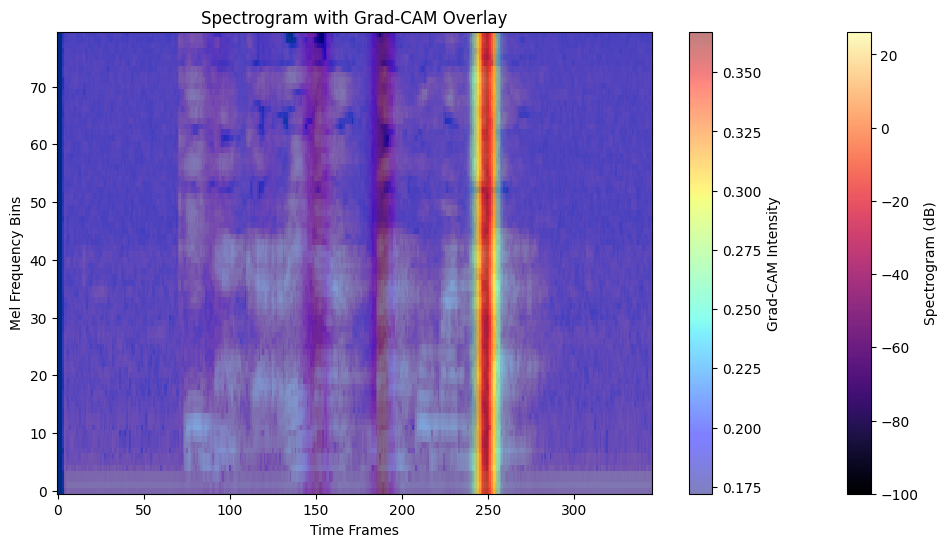

Processing: D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples2\common_voice_ca_40866683.mp3


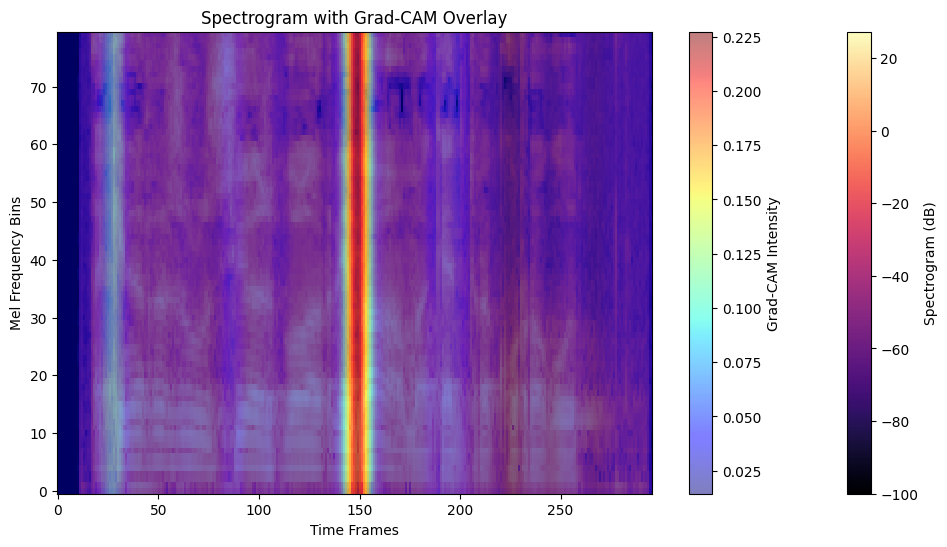

In [7]:
# call the function with the audio file path for all audio files in a folder
audio_folder = r"D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples2"
audio_files = os.listdir(audio_folder)

for audio_file in audio_files:
    audio_path = os.path.join(audio_folder, audio_file)
    print("Processing:", audio_path)
    plot_grad_cam_spectrogram(audio_path)



Processing: D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples2\common_voice_ca_40865427.mp3


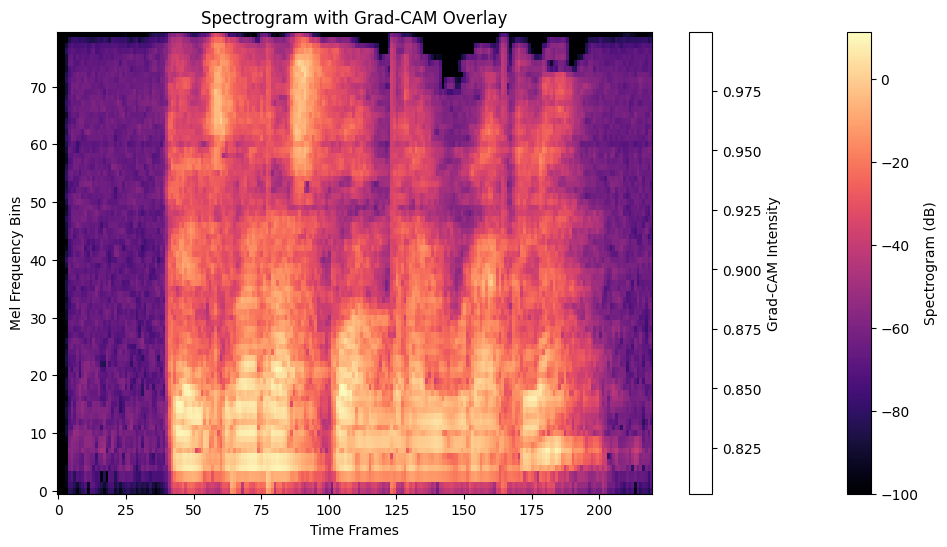

Processing: D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples2\common_voice_ca_40865467.mp3


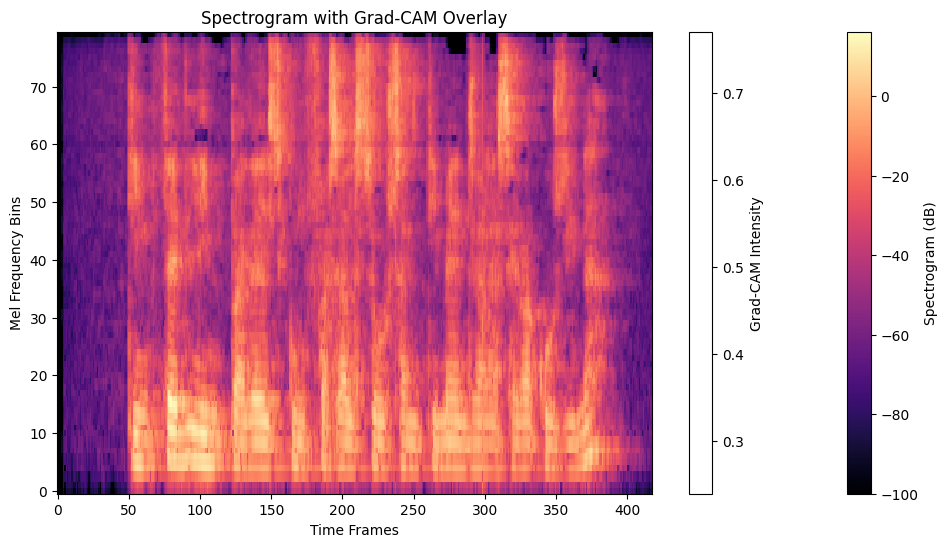

Processing: D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples2\common_voice_ca_40866081.mp3


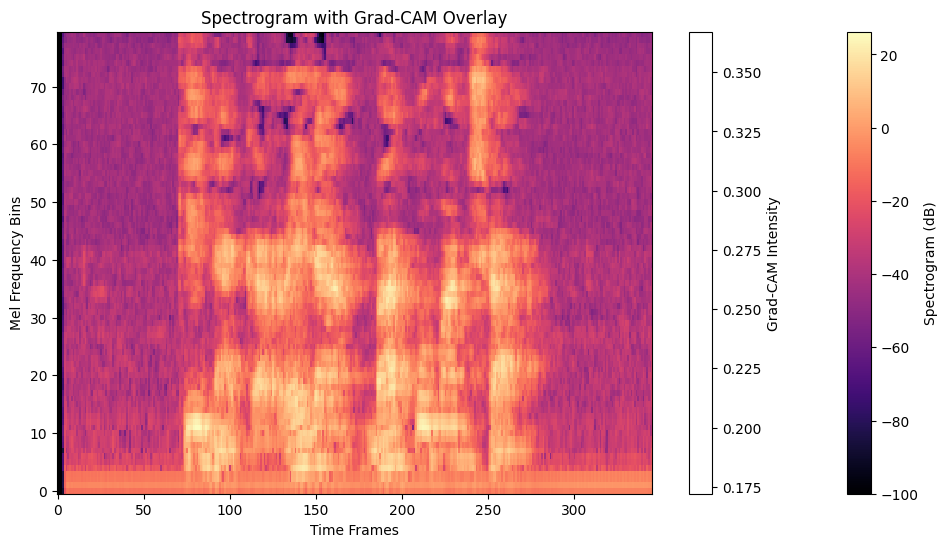

Processing: D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples2\common_voice_ca_40866683.mp3


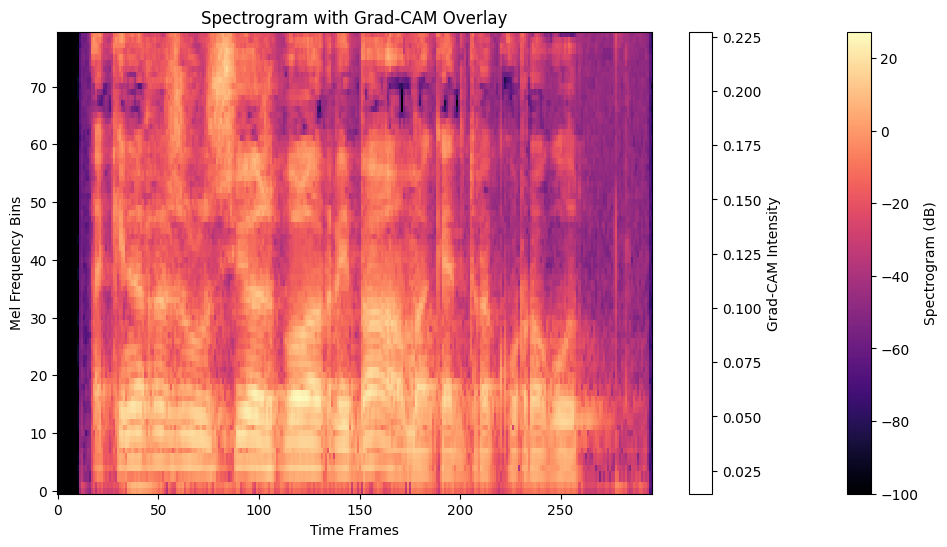

In [10]:
# call the function with the audio file path for all audio files in a folder
audio_folder = r"D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples2"
audio_files = os.listdir(audio_folder)

for audio_file in audio_files:
    audio_path = os.path.join(audio_folder, audio_file)
    print("Processing:", audio_path)
    plot_grad_cam_spectrogram(audio_path)



# PART 3

In [8]:
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor

model_name = "softcatala/wav2vec2-large-xlsr-catala"
processor = Wav2Vec2Processor.from_pretrained(model_name)
model = Wav2Vec2ForCTC.from_pretrained(model_name)


C:\Users\Usuario\AppData\Roaming\Python\Python311\site-packages\transformers\configuration_utils.py:306: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Invalid model-index. Not loading eval results into CardData.


Processing: D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples2\common_voice_ca_40865427.mp3
Processing: D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples2\common_voice_ca_40865427.mp3
Shape of pooled_gradients: torch.Size([1, 1024])
Shape of activation_map: torch.Size([1, 109, 1024])


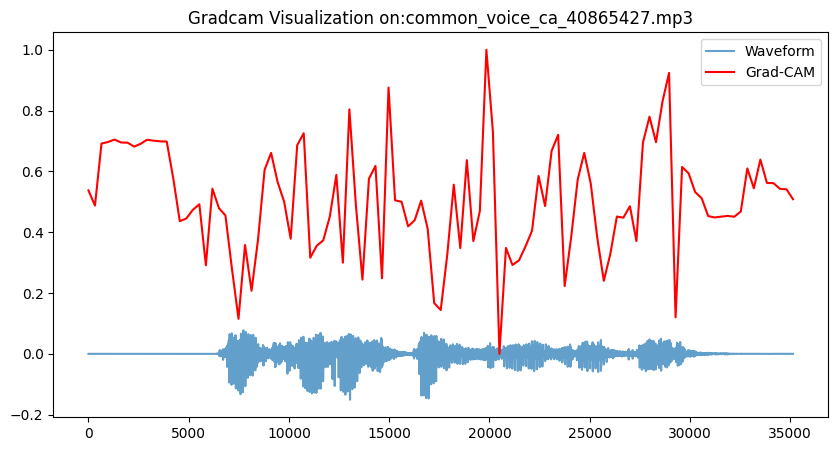

Processing: D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples2\common_voice_ca_40865467.mp3
Processing: D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples2\common_voice_ca_40865467.mp3
Shape of pooled_gradients: torch.Size([1, 1024])
Shape of activation_map: torch.Size([1, 208, 1024])


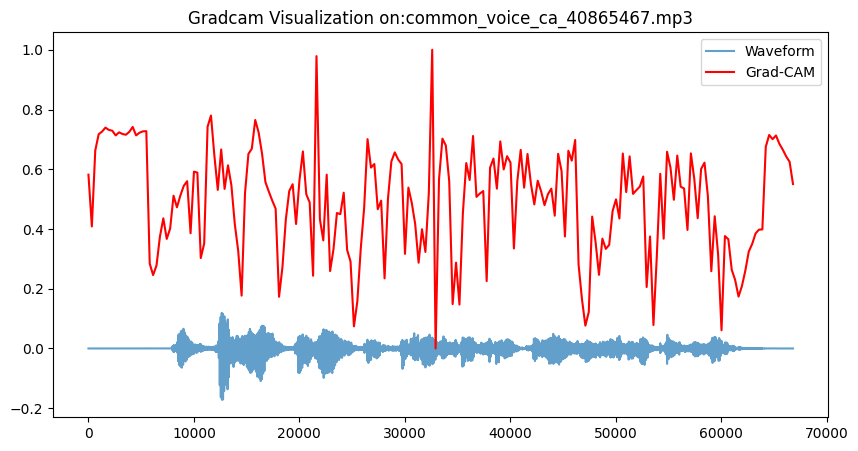

Processing: D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples2\common_voice_ca_40866081.mp3
Processing: D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples2\common_voice_ca_40866081.mp3
Shape of pooled_gradients: torch.Size([1, 1024])
Shape of activation_map: torch.Size([1, 172, 1024])


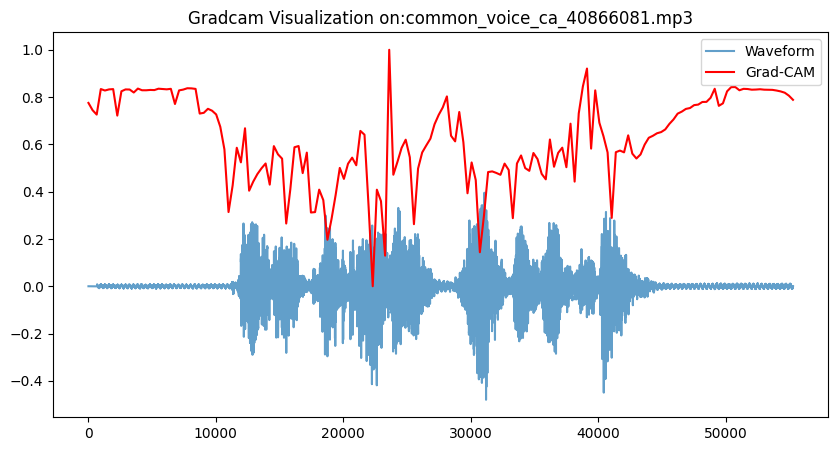

Processing: D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples2\common_voice_ca_40866683.mp3
Processing: D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples2\common_voice_ca_40866683.mp3
Shape of pooled_gradients: torch.Size([1, 1024])
Shape of activation_map: torch.Size([1, 147, 1024])


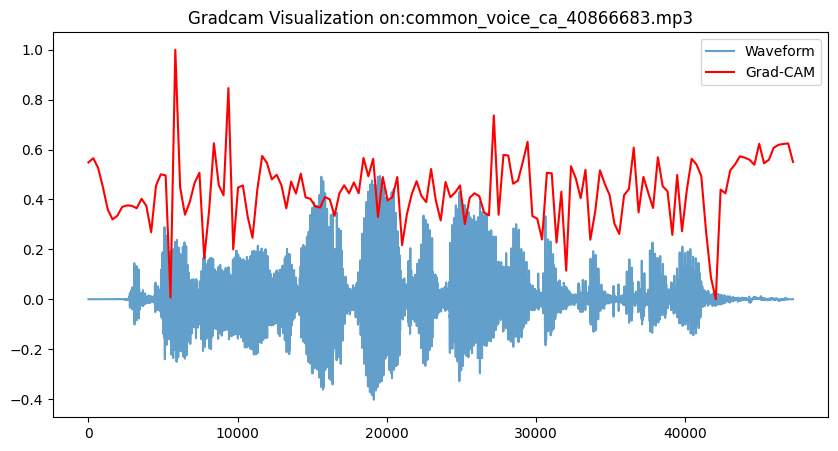

In [10]:
#iterate over the files in the folder
import os

audio_folder = r"D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples2"
audio_files = os.listdir(audio_folder)

for audio_file in audio_files:
    audio_path = os.path.join(audio_folder, audio_file)
    print("Processing:", audio_path)
    compute_gradcam(audio_path)

Processing: D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples2\common_voice_ca_40865427.mp3
Processing: D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples2\common_voice_ca_40865427.mp3
Shape of pooled_gradients: torch.Size([1, 1024])
Shape of activation_map: torch.Size([1, 109, 1024])


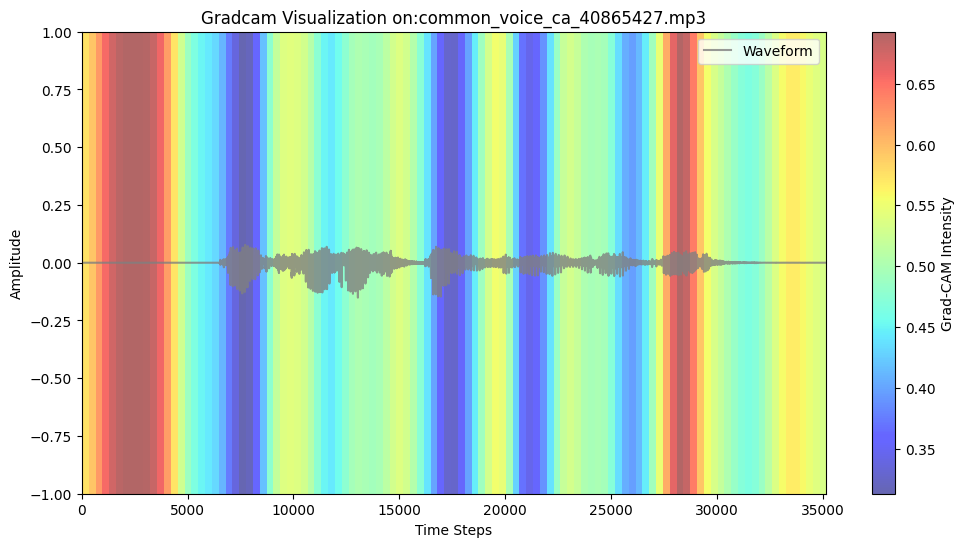

Processing: D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples2\common_voice_ca_40865467.mp3
Processing: D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples2\common_voice_ca_40865467.mp3
Shape of pooled_gradients: torch.Size([1, 1024])
Shape of activation_map: torch.Size([1, 208, 1024])


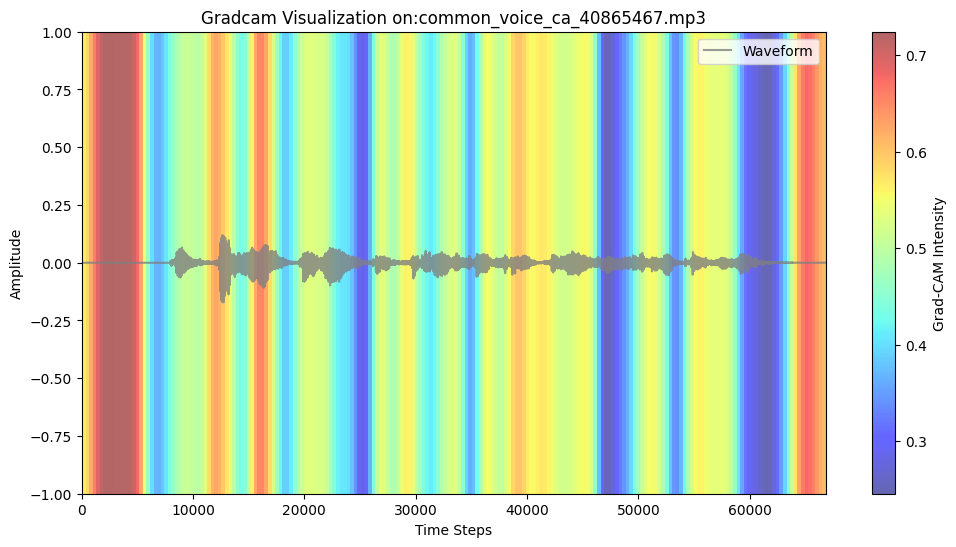

Processing: D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples2\common_voice_ca_40866081.mp3
Processing: D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples2\common_voice_ca_40866081.mp3
Shape of pooled_gradients: torch.Size([1, 1024])
Shape of activation_map: torch.Size([1, 172, 1024])


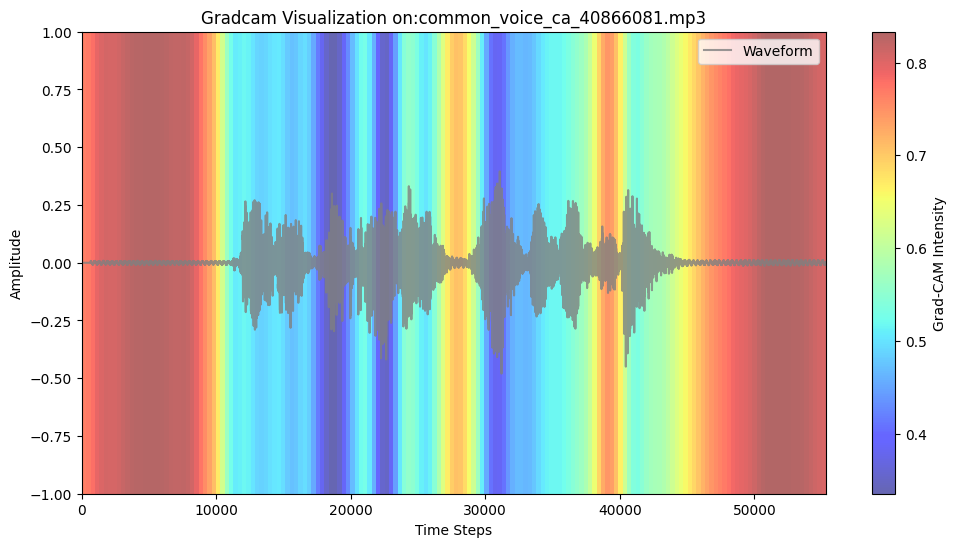

Processing: D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples2\common_voice_ca_40866683.mp3
Processing: D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples2\common_voice_ca_40866683.mp3
Shape of pooled_gradients: torch.Size([1, 1024])
Shape of activation_map: torch.Size([1, 147, 1024])


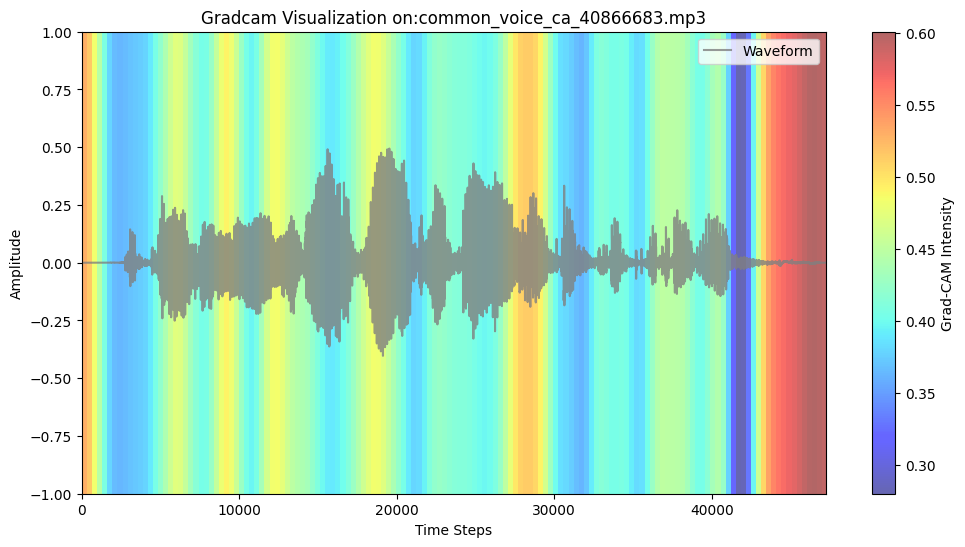

In [11]:
#compute Grad-CAM for all audio files in the folder
audio_folder = r"D:\Usuario\Desktop\Uni\4th year\Advanced Machine Learning\PROJECT GROUP\good_samples2"
audio_files = os.listdir(audio_folder)

for audio_file in audio_files:
    audio_path = os.path.join(audio_folder, audio_file)
    print("Processing:", audio_path)
    compute_gradcam_hm(audio_path)